L'équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation. Vous voulez tenter de prédire les **émissions de CO2 et la consommation totale d’énergie de bâtiments** pour lesquels elles **n’ont pas encore été mesurées**.
Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import datasets
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
pd.set_option('display.max_columns', None)
from scipy import stats
import os

In [2]:
def distance_IQ(dt, q1=0.25, q3=0.75):
    """
    Compute interquantile value and return number
    of elements 
        * Above Q3 + 1.5*IQ
        * Bellow Q1 - 1*5 IQ
    Arguments:
        _dt: dataFrame (pandas)
        _q1: first quantile (default 0.25)
        _q3: third quantile (default 0.75)
    """
    q1 = dt.quantile(q1)
    q3 = dt.quantile(q3)
    IQ = q3-q1
    count = dt[dt < q1 - 1.5* IQ ].count() 
    print("Element {0} bellow Q1 - 1.5 * IQ ({1:.2f})".format(count, q1 - 1.5* IQ))
    count = dt[dt > q3 + 1.5* IQ ].count() 
    print("Element {0} above Q3 + 1.5 * IQ ({1:.2f})".format(count ,q3 + 1.5 * IQ))

In [3]:
# datas liste de liste qui contient X, Y prédits et Y observés
def plot_pred_vs_obser(X, y, mdl, title = None, scalerX = None, scalerY = None):
    """
    Plot apply regression interoploation to X and plot graphic
        * Y predicted vs Y observed
    Arguments:
        _X: features dataframe
        _y: target dataframe
        _mdl: model use to regression
        _scalerX: scaler object to apply to X before perform regression
        _saclerY: scaler object to apply to Y invert normalization
    """
    if scalerX is None:
        X_scaled = X
    else:
        X_scaled = scalerX.transform(X)
    if scalerY is None:
        y_pred = mdl.predict(X_scaled)
    else:
        y_pred = scalerY.inverse_transform(mdl.predict(X_scaled))
    #plt.scatter(x, y, color = "blue", alpha = 0.3, label= "observé")
    R2 = r2_score(y, y_pred)
    print("L'erreur moyennen absolue du modèle: {0:.2f} kBtu".format(mean_absolute_error(y_pred, y)))
    print("R² {0:.4f}".format(R2))
    plt.scatter(y, y_pred,  color = "blue", alpha = 0.3)
    plt.xlabel("Y observé")
    plt.ylabel("Y prédit")
    plt.plot(y, y, label = "Valeurs attendues", color = "red")
    plt.text(1, 35, "R² = {0:.4f}".format(R2), verticalalignment='center')
    plt.title(title)
    plt.legend()
    plt.savefig(title+".png")
    plt.show()

In [4]:
def root_mean_squared_log_error(y_pred, y):
    """
    Compute RMSLE, a metric more robust against outliers
    Arguments:
        y_pred: numpy array
        y: numpy array
    """
    return np.sqrt(np.mean(np.log10(y_pred+1) - np.log10(y+1) )**2)

Variables d'intérêts:
* TotalGHGEmissions unit: (MetricTonsCO2e)
* GHGEmissionsIntensity unit: (kgCO2e/ft2)
* Electricity(kWh)

Abréviation:
* GHG Emissions : gaz à effet de serre.
* kBtu : kilo-British thermal unit. (1 kWh x 3.412 = 3.412 kBtu.)
* GFA (Gross Flor area) Surface hors œuvre brute (Floor area (building))

Unité:
* Surface space in square feet
* 1 kWh x 3.412 = 3.412 kBtu

**Energy star**
* Evaluate actual billed energy data
* Normalize for business activity (hours, workers, climate)
* Compare buildings to the national population
* Indicate the level of energy performance

Higher score means better performance

In [5]:
#Creation des dossiers
path = "./Energie"
os.makedirs(path, exist_ok=True)
path = "./CO2"
os.makedirs(path, exist_ok=True)
path = "./Distribution"
os.makedirs(path, exist_ok=True)

# Chargement des données

In [6]:
dt = pd.read_csv("clean_data.csv", sep =",", header = 0)
print("{0} lignes et colonnes {1}".format(dt.shape[0], dt.shape[1]))
dt = dt.drop(["Unnamed: 0"], axis=1)

1280 lignes et colonnes 42


In [7]:
dt.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,295.86,2.86
2,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18.0,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.0,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,505.01,2.88
3,9,2016,Nonresidential COS,Other,West Precinct,810 Virginia St,Seattle,WA,98101.0,0660000560,7,DOWNTOWN,47.61623,-122.33657,1999,1.0,2.0,97288,37198,60090,Police Station,Police Station,88830.0,NaN,NaN,NaN,136.100006,141.600006,316.299988,320.500000,12086616.0,12581712.0,0.0,2.160444e+06,7371434.0,47151.81641,4715182.0,False,Compliant,301.81,3.10
4,10,2016,NonResidential,Hotel,Camlin,1619 9th Avenue,Seattle,WA,98101.0,0660000825,7,DOWNTOWN,47.61390,-122.33283,1926,1.0,11.0,83008,0,83008,Hotel,Hotel,81352.0,NaN,NaN,27.0,70.800003,74.500000,146.600006,154.699997,5758795.0,6062767.5,0.0,8.239199e+05,2811215.0,29475.80078,2947580.0,False,Compliant,176.14,2.12


In [8]:
dt.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,1280.000000,1280.000000,1247.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1270.000000,658.000000,843.000000,1280.000000,1279.000000,1280.000000,1280.000000,1.280000e+03,1.279000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1280.000000,1.280000e+03,1280.000000,1280.000000
mean,17362.127344,2015.982031,98117.440257,4.296094,47.615637,-122.333614,1958.991406,1.020312,3.186719,70400.601562,8546.621094,61853.980469,57192.977165,20775.932062,66.285884,52.789219,55.191790,134.984141,137.827578,3.201654e+06,3.321844e+06,7.699301e+04,6.969040e+05,2.377838e+06,7243.159305,7.243158e+05,60.988203,0.986172
std,13117.328679,0.132890,18.557431,2.180800,0.047976,0.023301,33.198045,0.430894,3.831924,72358.004292,28138.187999,58123.150187,55137.893589,31587.779175,27.868714,34.065246,34.857311,97.862814,98.300955,3.233985e+06,3.319081e+06,4.611926e+05,7.973283e+05,2.720486e+06,11224.417339,1.122442e+06,74.574078,0.863435
min,1.000000,2015.000000,98006.000000,1.000000,47.509590,-122.411820,1900.000000,0.000000,0.000000,11285.000000,0.000000,10925.000000,5656.000000,0.000000,1.000000,0.700000,0.000000,0.000000,-2.100000,1.680890e+04,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000,0.000000e+00,-0.800000,-0.020000
25%,706.750000,2016.000000,98105.000000,2.000000,47.584275,-122.343280,1928.000000,1.000000,1.000000,27730.500000,0.000000,26516.750000,23852.250000,5000.000000,50.000000,30.000000,32.300001,67.674997,71.800001,1.045042e+06,1.103695e+06,0.000000e+00,1.780218e+05,6.074102e+05,0.000000,0.000000e+00,15.265000,0.310000
50%,21393.500000,2016.000000,98112.000000,4.000000,47.612300,-122.332820,1963.000000,1.000000,2.000000,43431.500000,0.000000,41223.000000,37060.000000,10304.500000,73.000000,46.900002,49.500000,117.250000,120.899998,1.946996e+06,2.038746e+06,0.000000e+00,3.746419e+05,1.278278e+06,3338.125000,3.338125e+05,36.730000,0.700000
75%,24705.750000,2016.000000,98125.000000,7.000000,47.649752,-122.322313,1986.000000,1.000000,4.000000,83556.500000,0.000000,73141.500000,67724.750000,23010.750000,89.000000,68.325003,71.199997,175.249996,177.749996,4.227754e+06,4.387392e+06,0.000000e+00,9.076249e+05,3.096816e+06,9532.277099,9.532278e+05,73.490000,1.410000
max,50226.000000,2016.000000,98199.000000,7.000000,47.733870,-122.261800,2015.000000,6.000000,99.000000,706176.000000,335109.000000,706176.000000,432903.000000,333698.000000,100.000000,262.600006,267.299988,781.299988,796.099976,1.527249e+07,1.697386e+07,6.568832e+06,4.390616e+06,1.498078e+07,88039.984380,8.803998e+06,563.250000,3.770000


In [9]:
for col in dt.columns:
    print("{0}: {1:.2f}% nan".format(col, dt[col].isna().sum()/dt.shape[0] *100))

OSEBuildingID: 0.00% nan
DataYear: 0.00% nan
BuildingType: 0.00% nan
PrimaryPropertyType: 0.00% nan
PropertyName: 0.00% nan
Address: 1.80% nan
City: 1.80% nan
State: 1.80% nan
ZipCode: 2.58% nan
TaxParcelIdentificationNumber: 0.00% nan
CouncilDistrictCode: 0.00% nan
Neighborhood: 0.00% nan
Latitude: 0.00% nan
Longitude: 0.00% nan
YearBuilt: 0.00% nan
NumberofBuildings: 0.00% nan
NumberofFloors: 0.00% nan
PropertyGFATotal: 0.00% nan
PropertyGFAParking: 0.00% nan
PropertyGFABuilding(s): 0.00% nan
ListOfAllPropertyUseTypes: 0.47% nan
LargestPropertyUseType: 0.78% nan
LargestPropertyUseTypeGFA: 0.78% nan
SecondLargestPropertyUseType: 48.59% nan
SecondLargestPropertyUseTypeGFA: 48.59% nan
ENERGYSTARScore: 34.14% nan
SiteEUI(kBtu/sf): 0.00% nan
SiteEUIWN(kBtu/sf): 0.08% nan
SourceEUI(kBtu/sf): 0.00% nan
SourceEUIWN(kBtu/sf): 0.00% nan
SiteEnergyUse(kBtu): 0.00% nan
SiteEnergyUseWN(kBtu): 0.08% nan
SteamUse(kBtu): 0.00% nan
Electricity(kWh): 0.00% nan
Electricity(kBtu): 0.00% nan
NaturalGas(t

Text(0.5, 1.0, "Energie score en fonction de l'énergie/pied²")

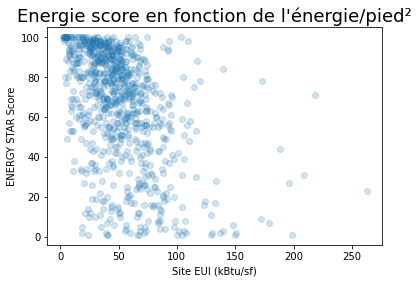

In [10]:
indice = dt["ENERGYSTARScore"].isna()
z = dt.loc[~indice, ["ENERGYSTARScore"]].to_numpy()
y = dt.loc[~indice, ["GHGEmissionsIntensity"]].to_numpy()
x = dt.loc[~indice, ["SiteEUI(kBtu/sf)"]].to_numpy()
plt.scatter(x, z, alpha = 0.2)
plt.ylabel("ENERGY STAR Score")
plt.xlabel("Site EUI (kBtu/sf)")
plt.title("Energie score en fonction de l'énergie/pied²", size=18)

Text(0.5, 1.0, 'Energie score en fonction de GHG Emissions')

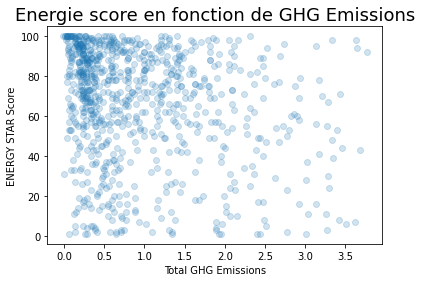

In [11]:
plt.scatter(y, z, alpha = 0.2)
plt.ylabel("ENERGY STAR Score")
plt.xlabel("Total GHG Emissions")
plt.title("Energie score en fonction de GHG Emissions", size=18)

# Proportion des bâtiments

In [12]:
def CountGroup(dt, colName):
    """
    Count labels'elements
    Argument:
        _dt: dataframe 
        _colName (str): columns's name
    Return:
        counts: list with labels's frequency
        labels: list of labels found
    """
    counts = []
    labels = []
    for label in dt[colName].unique():
        tmp = dt[colName] == label
        #count True
        counts.append(sum(tmp)/len(tmp)*100)
        labels.append(label)
    return counts, labels

In [13]:
counts, labels = CountGroup(dt, 'BuildingType')
print(counts)
print(labels)

[93.90625, 4.6875, 0.703125, 0.703125]
['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus']


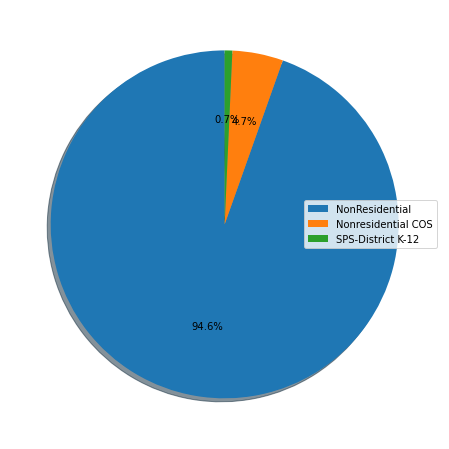

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(counts[:-1], autopct='%.1f%%', shadow=True, startangle=90)
ax.legend(labels[:-1], loc='right')
ax.set_aspect('equal')
plt.savefig("./Distribution/proportion_buildingType.png")
plt.show()

## Non residential

Bâtiment qui occupe le plus de superficie dans la catégorie **Non residential**

In [15]:
sub_dt = dt.loc[dt['BuildingType'] == 'NonResidential', ['LargestPropertyUseType']]
counts, labels = CountGroup(sub_dt, 'LargestPropertyUseType')
#print(counts)
print(labels)

['Hotel', 'Other - Entertainment/Public Assembly', 'College/University', 'Automobile Dealership', 'Office', 'Self-Storage Facility', 'K-12 School', 'Other - Mall', 'Retail Store', 'Other', 'Museum', 'Other - Lodging/Residential', 'Residence Hall/Dormitory', 'Financial Office', 'Non-Refrigerated Warehouse', 'Parking', 'Multifamily Housing', 'Senior Care Community', 'Worship Facility', nan, 'Laboratory', 'Urgent Care/Clinic/Other Outpatient', 'Medical Office', 'Distribution Center', 'Supermarket/Grocery Store', 'Strip Mall', 'Wholesale Club/Supercenter', 'Refrigerated Warehouse', 'Manufacturing/Industrial Plant', 'Lifestyle Center', 'Other - Public Services', 'Restaurant', 'Social/Meeting Hall', 'Performing Arts', 'Other - Recreation', 'Other - Services', 'Bank Branch', 'Other/Specialty Hospital', 'Food Service', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Adult Education', 'Other - Utility', 'Other - Education', 'Movie Theater', 'Outpatient Rehabilitation/Physical Therapy', 'Per

[4.492512479201332, 0.9151414309484194, 1.1647254575707155, 0.4159733777038269, 34.026622296173045, 2.246256239600666, 3.0782029950083194, 0.08319467554076539, 6.821963394342761, 4.7420965058236275, 0.16638935108153077, 0.4159733777038269, 1.5806988352745424, 0.33277870216306155, 15.307820299500833, 1.8302828618968388, 0.8319467554076538, 0.9151414309484194, 5.823627287853577, 0.0, 0.16638935108153077, 0.16638935108153077, 2.4126455906821964, 4.242928452579035, 1.0815307820299502, 0.4159733777038269, 0.08319467554076539, 0.8319467554076538, 0.49916805324459235, 0.08319467554076539, 0.16638935108153077, 0.4159733777038269, 0.7487520798668885, 0.16638935108153077, 0.4159733777038269, 0.16638935108153077, 0.33277870216306155, 0.16638935108153077, 0.08319467554076539, 0.33277870216306155, 0.08319467554076539, 0.08319467554076539, 0.16638935108153077, 0.08319467554076539, 0.08319467554076539, 0.08319467554076539, 0.08319467554076539, 0.16638935108153077, 0.16638935108153077]


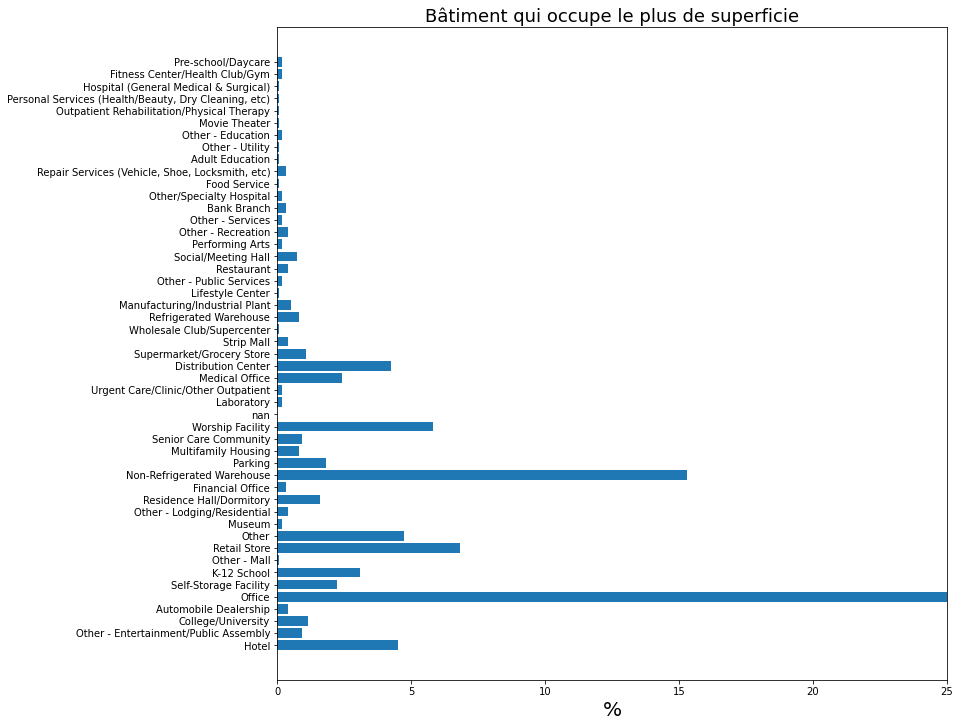

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))
#pourcentage des différents salaries dans le monde
print(counts)
y_pos = [i for i, _ in enumerate(labels)]
plt.barh(y_pos, counts)
#position pour les labels
plt.yticks(y_pos, labels)
#Axes et titre
plt.title("Bâtiment qui occupe le plus de superficie", size = 18)
plt.xlabel("%", size=20)
plt.xlim(0, 25)
plt.savefig("./Distribution/hist_PrimaryBuilding.png")
plt.show()

La catégorie **Non Residential** comporte une grande variété de bâtiment allant d'établissement scolaire à des hôpitaux, commerces ou bien d'entrepôts.

# Distribution des variables quantitatives

C:\Users\jayse\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


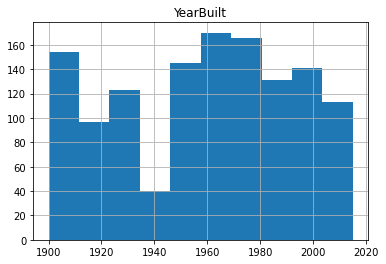

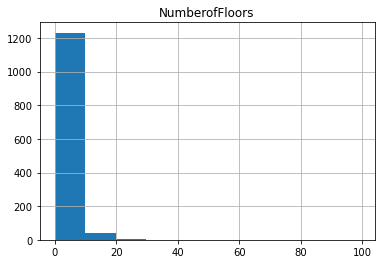

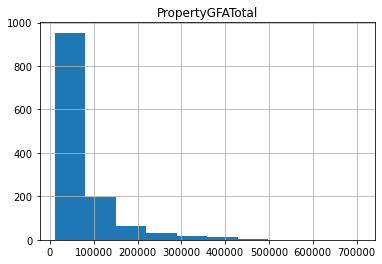

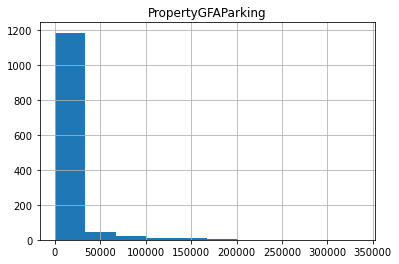

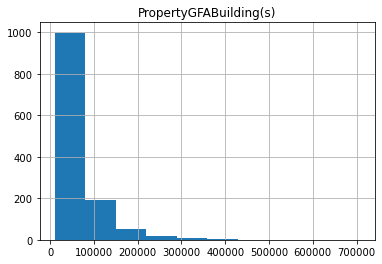

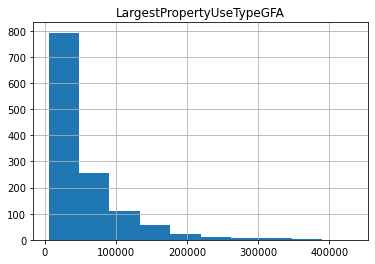

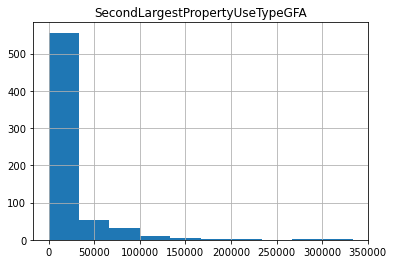

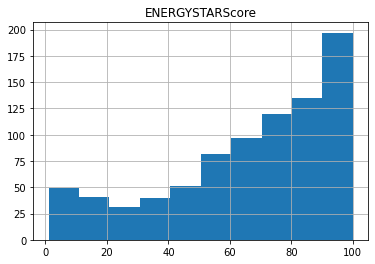

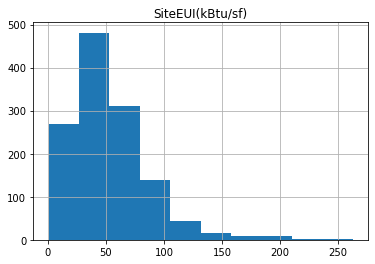

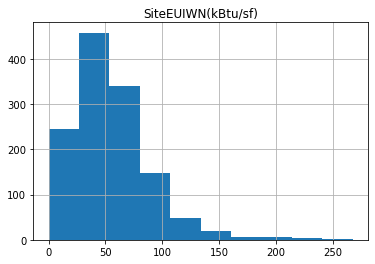

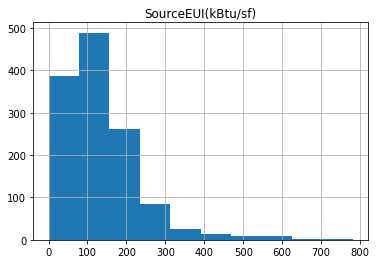

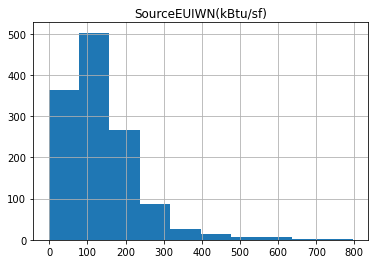

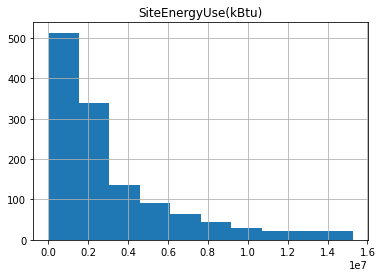

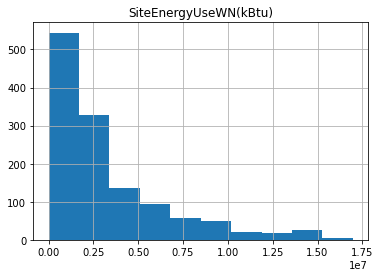

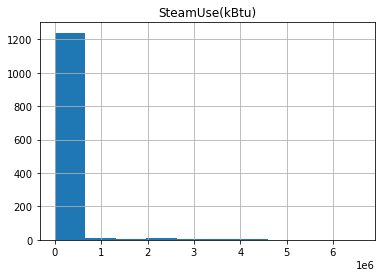

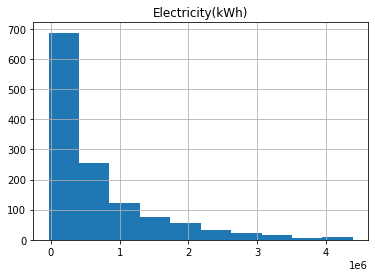

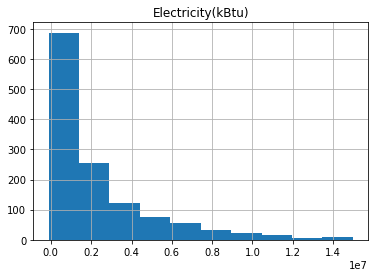

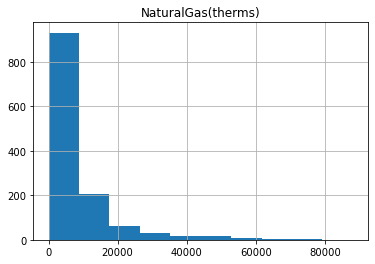

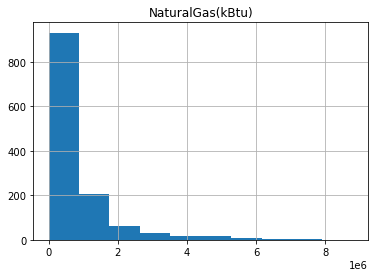

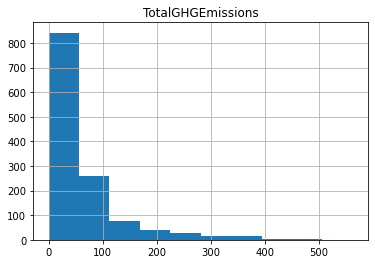

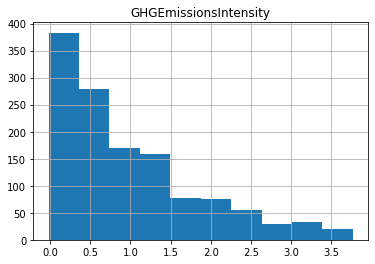

In [17]:
for col in dt.describe().columns[6:]:
    if col in ['NumberofBuildings']:
        continue
    dt.hist(column=col)

In [18]:
dt['BuildingType'].value_counts()

NonResidential        1202
Nonresidential COS      60
Campus                   9
SPS-District K-12        9
Name: BuildingType, dtype: int64

In [19]:
dt['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    285
Other                          182
Warehouse                      179
Large Office                   105
Mixed Use Property              87
Retail Store                    79
Worship Facility                71
Hotel                           54
Distribution Center             52
K-12 School                     48
Medical Office                  29
Self-Storage Facility           28
Residence Hall                  19
University                      15
Supermarket / Grocery Store     13
Senior Care Community           11
Refrigerated Warehouse          10
Restaurant                       6
Low-Rise Multifamily             3
Non-Refrigerated Warehouse       2
Laboratory                       1
Hospital                         1
Name: PrimaryPropertyType, dtype: int64

# Consommation d'énergie

In [20]:
dt.loc[:,["SiteEnergyUse(kBtu)", "SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)"]].head()
#dt.loc[:,["SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)"]].sum(axis=1)

,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
0,7226362.5,2003882.0,3946027.0,1276453.0
1,8387933.0,0.0,3242851.0,5145082.0
2,14172606.0,0.0,5368607.0,8803998.0
3,12086616.0,0.0,7371434.0,4715182.0
4,5758795.0,0.0,2811215.0,2947580.0


L'énergie total est SiteEnergyUse(kBtu). C'est la composante de SteamUse(kBtu), Electricity(kBtu) et NaturalGas(kBtu)

In [21]:
cons_kBtu = dt.loc[:,["OSEBuildingID", "BuildingType", "PrimaryPropertyType", "SiteEnergyUse(kBtu)", "SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)"]].head()


**SiteEnergyUse(kBtu)** renseigne sur la consommation d'énergie de l'immeuble. La variable **SiteEUI(kBtu/sf)** normalise l'énergie par la surperficie de l'immeuble

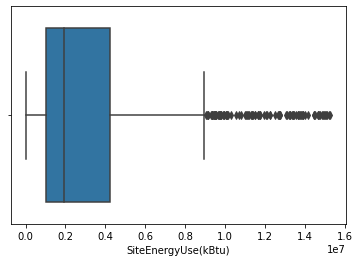

In [22]:
ax = sns.boxplot(x=dt["SiteEnergyUse(kBtu)"])
plt.savefig("./Distribution/boxplot_energie.png")

In [23]:
dt["SiteEnergyUse(kBtu)"].describe()

count    1.280000e+03
mean     3.201654e+06
std      3.233985e+06
min      1.680890e+04
25%      1.045042e+06
50%      1.946996e+06
75%      4.227754e+06
max      1.527249e+07
Name: SiteEnergyUse(kBtu), dtype: float64

In [24]:
distance_IQ(dt["SiteEnergyUse(kBtu)"], q1=0.25, q3=0.75)

Element 0 bellow Q1 - 1.5 * IQ (-3729025.17)
Element 97 above Q3 + 1.5 * IQ (9001820.70)


In [25]:
dt[dt["SiteEnergyUse(kBtu)"] > 9001820.70].shape

(97, 41)

Il y a 97 bâtiments outliers qui sont présents dans 4 catégories de bâtiments

## Consommation par type de bâtiment

In [26]:
dt.groupby(by='BuildingType').agg('count')["OSEBuildingID"]

BuildingType
Campus                   9
NonResidential        1202
Nonresidential COS      60
SPS-District K-12        9
Name: OSEBuildingID, dtype: int64

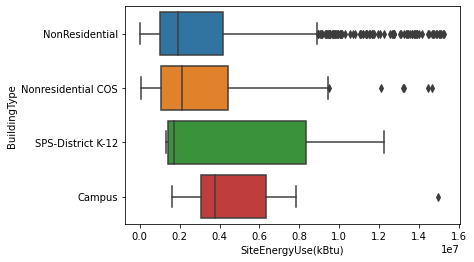

In [27]:
f, ax = plt.subplots()
ax = sns.boxplot(x=dt["SiteEnergyUse(kBtu)"], y = dt['BuildingType'])
plt.savefig("./Distribution/boxplot_energie_Building.png")

In [28]:
dt.groupby(by='BuildingType').agg('mean')["SiteEnergyUse(kBtu)"]

BuildingType
Campus                5.390687e+06
NonResidential        3.145136e+06
Nonresidential COS    3.726362e+06
SPS-District K-12     5.062857e+06
Name: SiteEnergyUse(kBtu), dtype: float64

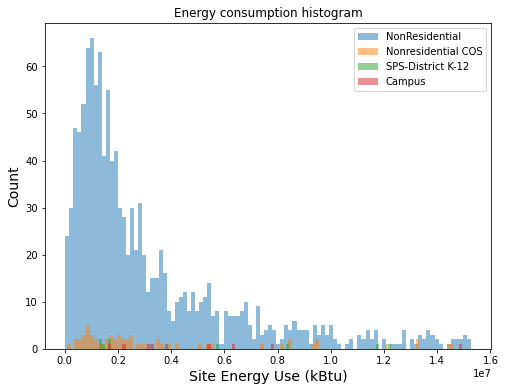

In [29]:
plt.figure(figsize=(8,6))


kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=20)
for build in pd.unique(dt['BuildingType'].values):
    if build == 'Nonresidential WA':
        continue
    else:
        ind = dt['BuildingType'] == build
        data = dt.loc[ind,['SiteEnergyUse(kBtu)']].values
        #plt.hist(data.reshape(-1), **kwargs)
        plt.hist(data.reshape(-1), bins=100, alpha=0.5, label=build)

plt.xlabel("Site Energy Use (kBtu)", size=14)
plt.ylabel("Count", size=14)
plt.title("Energy consumption histogram")
plt.legend(loc='upper right')
plt.savefig("./Distribution/hist_energy_Building.png")
plt.show()

In [30]:
dt.groupby(by='BuildingType').agg('mean')["SiteEnergyUse(kBtu)"]

BuildingType
Campus                5.390687e+06
NonResidential        3.145136e+06
Nonresidential COS    3.726362e+06
SPS-District K-12     5.062857e+06
Name: SiteEnergyUse(kBtu), dtype: float64

# Test ANOVA non paramétrique kruskal wallis

La distribution de l'énergie consommée est-elle la même ? Les distributions ne suivent pas une loi normale, le test Kruskal-Wallis est utilisé. On retire **Nonresidential WA**.
    
Rappel:
* H0: Les médiannes sont égales
* H1: Au moins une distribution est différente

In [31]:
x1 = dt.loc[dt['BuildingType'] == "NonResidential", "SiteEnergyUse(kBtu)"].values
x2 = dt.loc[dt['BuildingType'] == "Nonresidential COS", "SiteEnergyUse(kBtu)"].values
x3 = dt.loc[dt['BuildingType'] == "Campus", "SiteEnergyUse(kBtu)"].values
x4 = dt.loc[dt['BuildingType'] == "SPS-District K-12", "SiteEnergyUse(kBtu)"].values

In [32]:
stats.kruskal(x1, x2, x3,x4)

KruskalResult(statistic=8.63066338796716, pvalue=0.03462664080447488)

## Conclusion du test

La pvalue < 0.05 le test est significatif. Les consommations moyennes d'énergies sont différentes entre les types de bâtiments

# Emission de CO2

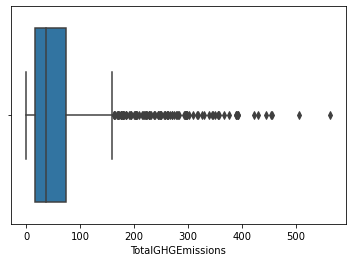

In [33]:
ax = sns.boxplot(x=dt["TotalGHGEmissions"])
plt.savefig("./Distribution/boxplot_Co2.png")

In [34]:
dt["TotalGHGEmissions"].describe()

count    1280.000000
mean       60.988203
std        74.574078
min        -0.800000
25%        15.265000
50%        36.730000
75%        73.490000
max       563.250000
Name: TotalGHGEmissions, dtype: float64

## Consommation par type de bâtiment

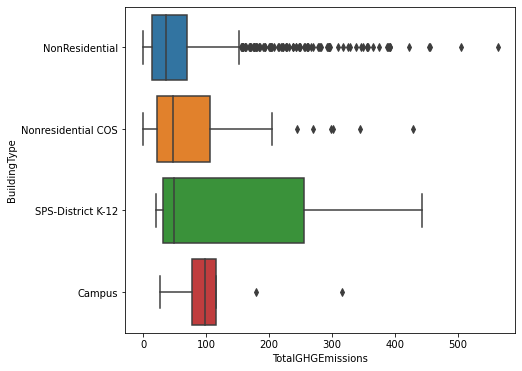

In [35]:
f, ax = plt.subplots(figsize=(7, 6))
ax = sns.boxplot(x=dt["TotalGHGEmissions"], y =dt['BuildingType'])
plt.savefig("./Distribution/boxplot_Co2_Building.png")

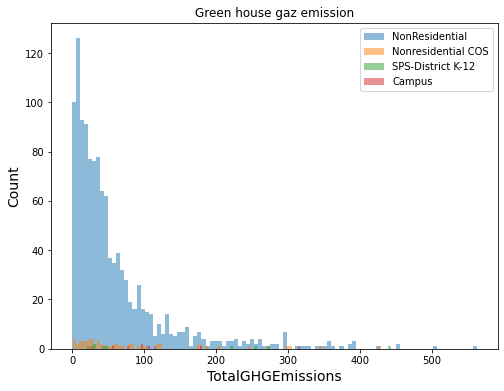

In [36]:
plt.figure(figsize=(8,6))


kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=20)
for build in pd.unique(dt['BuildingType'].values):
    if build == 'Nonresidential WA':
        continue
    else:
        ind = dt['BuildingType'] == build
        data = dt.loc[ind,['TotalGHGEmissions']].values
        #plt.hist(data.reshape(-1), **kwargs)
        plt.hist(data.reshape(-1), bins=100, alpha=0.5, label=build)

plt.xlabel("TotalGHGEmissions", size=14)
plt.ylabel("Count", size=14)
plt.title("Green house gaz emission")
plt.legend(loc='upper right')
plt.savefig("./Distribution/hist_Co2_Building.png")
plt.show()

In [37]:
dt.groupby(by='BuildingType').agg('mean')["TotalGHGEmissions"]

BuildingType
Campus                119.230000
NonResidential         58.722879
Nonresidential COS     83.956667
SPS-District K-12     152.170000
Name: TotalGHGEmissions, dtype: float64

# Test ANOVA non paramétrique kruskal wallis

La distribution de l'émission de CO2 est-elle la même ? Les distributions ne suivent pas une loi normale, le test Kruskal-Wallis est utilisé. On retire **Nonresidential WA**.
    
Rappel:
* H0: Les médiannes sont égales
* H1: Au moins une distribution est différente

In [38]:
x1 = dt.loc[dt['BuildingType'] == "NonResidential", "TotalGHGEmissions"].values
x2 = dt.loc[dt['BuildingType'] == "Nonresidential COS", "TotalGHGEmissions"].values
x3 = dt.loc[dt['BuildingType'] == "Campus", "TotalGHGEmissions"].values
x4 = dt.loc[dt['BuildingType'] == "SPS-District K-12", "TotalGHGEmissions"].values

In [39]:
stats.kruskal(x1, x2, x3,x4)

KruskalResult(statistic=17.648571384607607, pvalue=0.0005196956111227515)

## Conclusion du test

La pvalue < 0.05 le test est significatif. Les émmissions moyennes de gaz à effet de serre sont différents entre les types de bâtiments.

# Primary Property Type

La consomation moyenne d'énergie et l'émission de CO2 étant différent pour le type de bâtiment, on va annalyser la consommation suivant le type du local qui occupe le plus de surface dans chaque bâtiment.

In [40]:
dt['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    285
Other                          182
Warehouse                      179
Large Office                   105
Mixed Use Property              87
Retail Store                    79
Worship Facility                71
Hotel                           54
Distribution Center             52
K-12 School                     48
Medical Office                  29
Self-Storage Facility           28
Residence Hall                  19
University                      15
Supermarket / Grocery Store     13
Senior Care Community           11
Refrigerated Warehouse          10
Restaurant                       6
Low-Rise Multifamily             3
Non-Refrigerated Warehouse       2
Laboratory                       1
Hospital                         1
Name: PrimaryPropertyType, dtype: int64

In [41]:
counts, labels = CountGroup(dt, 'PrimaryPropertyType')
print(counts)
print(labels)

[4.21875, 14.21875, 1.171875, 22.265625, 2.1875, 3.75, 8.203125, 6.171875, 1.484375, 13.984374999999998, 4.0625, 6.796874999999999, 0.8593750000000001, 5.546875, 2.265625, 1.015625, 0.15625, 0.78125, 0.234375, 0.46875, 0.078125, 0.078125]
['Hotel', 'Other', 'University', 'Small- and Mid-Sized Office', 'Self-Storage Facility', 'K-12 School', 'Large Office', 'Retail Store', 'Residence Hall', 'Warehouse', 'Distribution Center', 'Mixed Use Property', 'Senior Care Community', 'Worship Facility', 'Medical Office', 'Supermarket / Grocery Store', 'Non-Refrigerated Warehouse', 'Refrigerated Warehouse', 'Low-Rise Multifamily', 'Restaurant', 'Laboratory', 'Hospital']


<ipython-input-42-b3e373ecae20>:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(counts, labels,


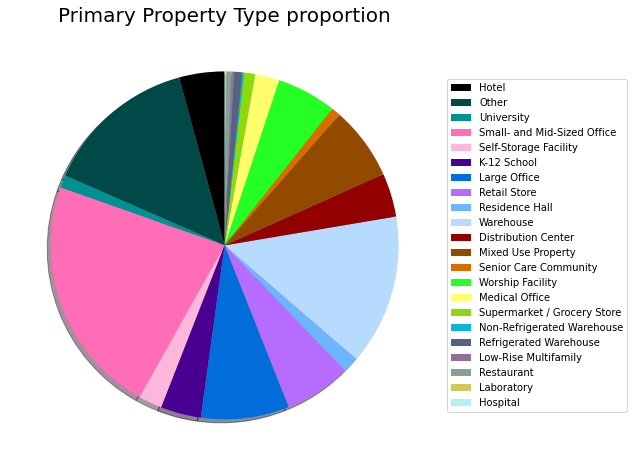

In [42]:
from matplotlib import cm

fig, ax = plt.subplots(figsize=(10, 8))
pal = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d",
 "#8CDA0C", "#0CB5DA", "#566380", "#936E9C", "#83A294",
 "#CFC958", "#B5EFF1"]
ax.pie(counts, shadow=True, startangle=90,  colors=pal)
#ax.pie(counts, shadow=True, startangle=90)

#ax.legend(labels[:-1], loc='right')

ax.legend(counts, labels,
          labels=labels,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_aspect('equal')
#plt.savefig("./Distribution/proportion_buildingType.png")
ax.set_title("Primary Property Type proportion", size = 20)
plt.show()

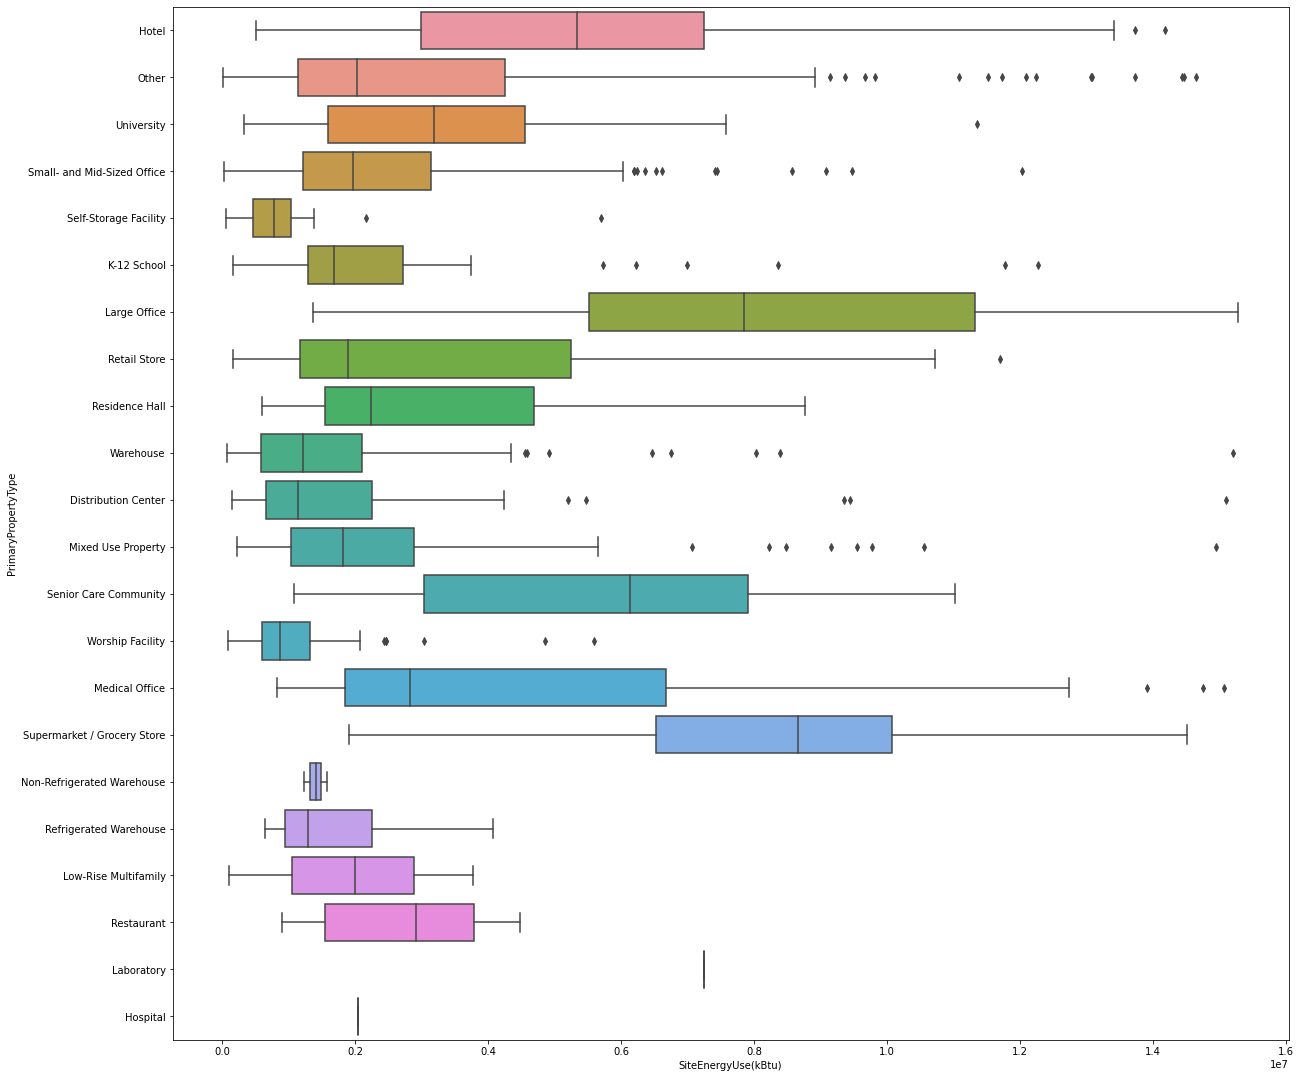

In [43]:
f, ax = plt.subplots(figsize=(20, 19))
ax = sns.boxplot(x=dt["SiteEnergyUse(kBtu)"], y =dt['PrimaryPropertyType'])
plt.savefig("./Distribution/hist_energy_PrimaryPropertyType.png")

Si on classe les bâtiments par rapport à la classe du bâtiment qui occupe le plus de surface.

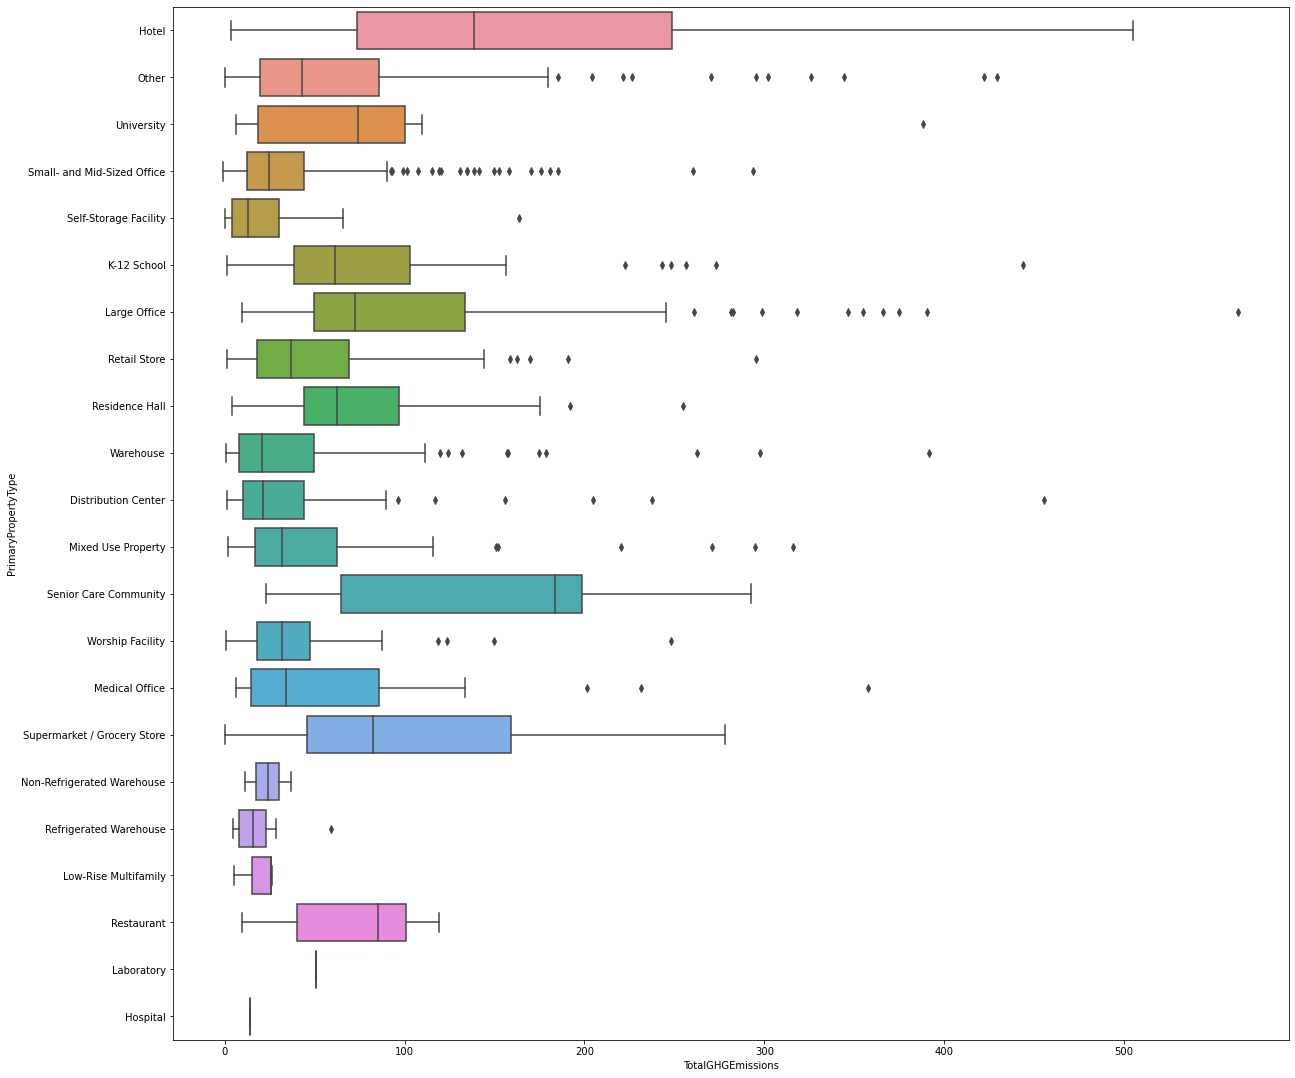

In [44]:
f, ax = plt.subplots(figsize=(20, 19))
ax = sns.boxplot(x=dt["TotalGHGEmissions"], y =dt['PrimaryPropertyType'])
plt.savefig("./Distribution/hist_CO2_PrimaryPropertyType.png")

Les distributions des consommations d'énergie et d'émission de CO2 ne sont pas les mêmes. Certains type de local ont de grandes disparités dans leur distribution (*large office*, *medical office*...). Cette variable est pertinente à utiliser.

# Corrélation entre les variables

In [45]:
new_dt = dt.iloc[:,7:-1]

In [46]:
new_dt.head()

,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions
0,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,249.98
1,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,295.86
2,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18.0,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.0,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,505.01
3,WA,98101.0,0660000560,7,DOWNTOWN,47.61623,-122.33657,1999,1.0,2.0,97288,37198,60090,Police Station,Police Station,88830.0,NaN,NaN,NaN,136.100006,141.600006,316.299988,320.500000,12086616.0,12581712.0,0.0,2.160444e+06,7371434.0,47151.81641,4715182.0,False,Compliant,301.81
4,WA,98101.0,0660000825,7,DOWNTOWN,47.61390,-122.33283,1926,1.0,11.0,83008,0,83008,Hotel,Hotel,81352.0,NaN,NaN,27.0,70.800003,74.500000,146.600006,154.699997,5758795.0,6062767.5,0.0,8.239199e+05,2811215.0,29475.80078,2947580.0,False,Compliant,176.14


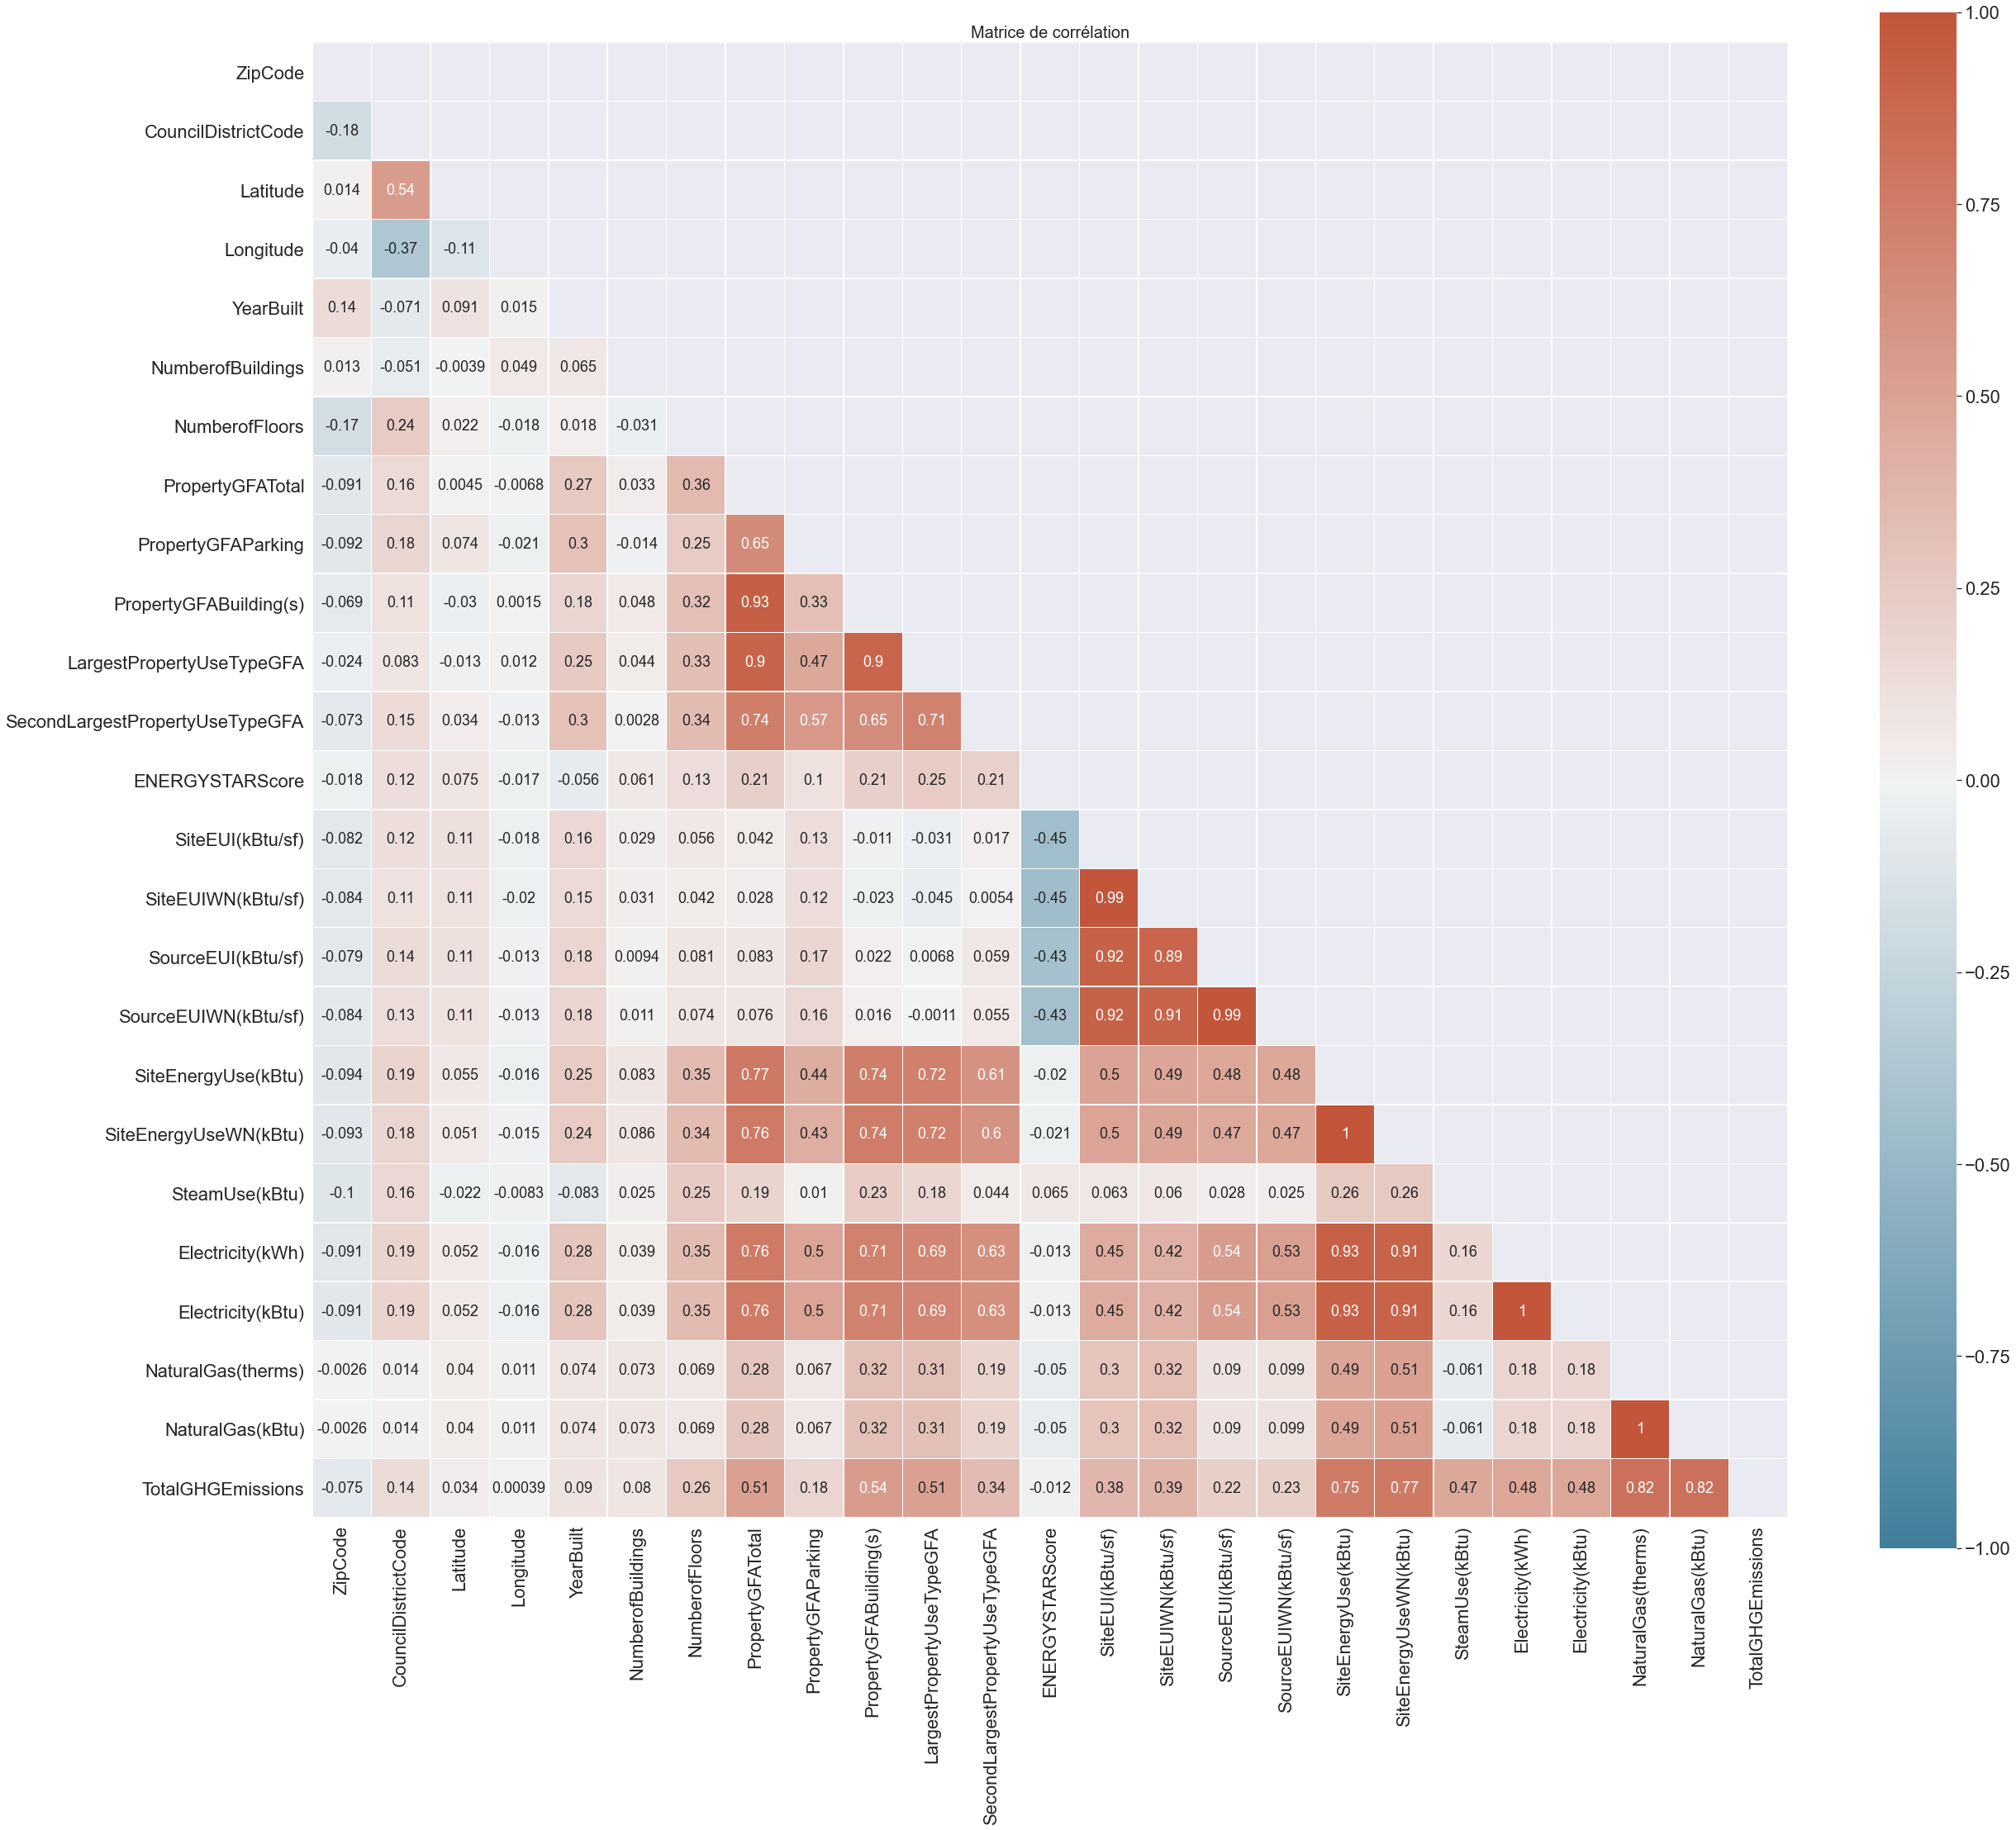

In [47]:
# matrice de corrélation
corr = dt.iloc[:,6:-1].corr()
sns.set(font_scale=2)
# on génère un masque pour affiche la moitié de la matrice
mask = np.triu(np.ones_like(corr, dtype=bool))
# fig
f, ax = plt.subplots(figsize=(40, 38))

# Palette de couleur
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Matrice
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .9}, 
            vmin = -1, vmax = 1, annot = True, annot_kws = {"size": 18})
plt.title("Matrice de corrélation", size = 20)
plt.savefig("Matrice de corrélation.png")

Il y a une corrélation entre **SiteEnergyUse(kBtu)** et **PropertyGFABuilding(s)**, **TotalGHGEmissions** et **SiteEnergyUse(kBtu)** qui est lui même corrélé avec **PropertyGFABuilding(s)**

In [48]:
def scatter_plot(dt, label1, label2, title, path = None):
    x = dt.loc[:,label1].to_numpy()
    y = dt.loc[:,label2].to_numpy()
    #ax = plt.subplot(111)
    #ax.scatter(x, y, marker = '+')
    #plt.xlabel(label1)
    #plt.ylabel(label2)
    sns.jointplot(data=dt, x = label1, y= label2,  marker="+", 
              s=100, marginal_kws=dict(bins=25))
    plt.title(title, size = 20)
    if path is not None:
        plt.savefig(path)
    #ax.legend(loc='best')
    plt.show()

# Consommation d'énergie vs surperficie

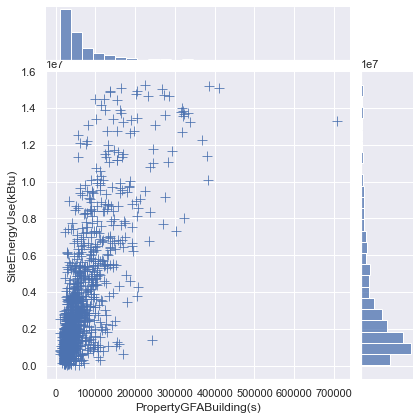

In [49]:
sns.set(font_scale=1)
scatter_plot(dt, "PropertyGFABuilding(s)", "SiteEnergyUse(kBtu)", "", "./Energie/Energie_vs_Surface_raw.png")

Si on retire les bâtiments qui ont une surface > à 20 000 pieds²

(1237, 41)


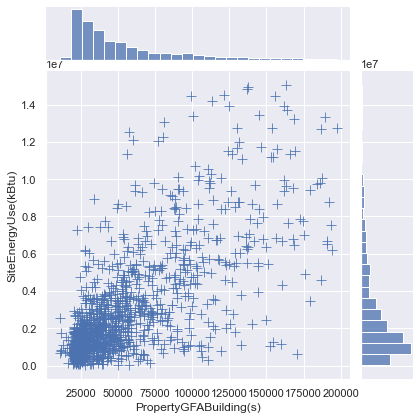

In [50]:
print(dt.loc[dt["PropertyGFABuilding(s)"]< 200000].shape)
tmp_dt = dt.loc[dt["PropertyGFABuilding(s)"]< 200000]
sns.set(font_scale=1)
scatter_plot(tmp_dt, "PropertyGFABuilding(s)", "SiteEnergyUse(kBtu)", "", "./Energie/Energie_vs_Surface.png")


Passage au logarithme pour étendre la représentation.

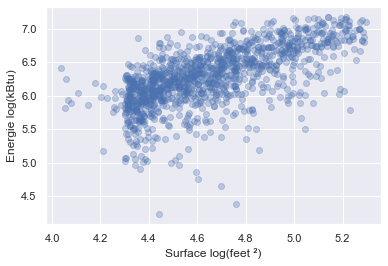

In [51]:
x = tmp_dt["PropertyGFABuilding(s)"].to_numpy()
y = tmp_dt["SiteEnergyUse(kBtu)"].to_numpy()
plt.scatter(np.log10(x), np.log10(y), alpha = 0.3)
plt.xlabel("Surface log(feet ²)")
plt.ylabel("Energie log(kBtu)")
plt.savefig("./Energie/Energie_vs_Surface_log.png")

# Emission de CO2 vs surperficie

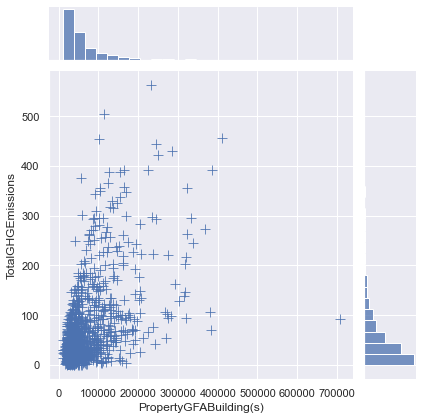

In [52]:
sns.set(font_scale=1)
scatter_plot(dt, "PropertyGFABuilding(s)", "TotalGHGEmissions", "", "./CO2/CO2_vs_Surface_raw.png")

Si on retire les bâtiments qui ont une surface > à 20 000 pieds²

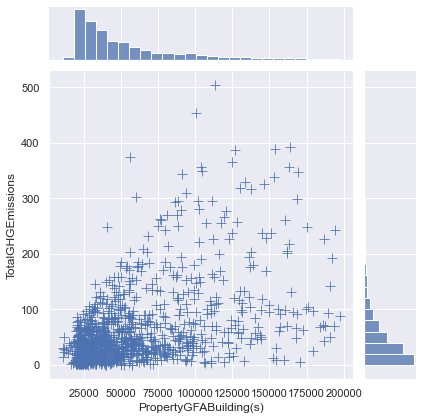

(1237, 41)


In [53]:
sns.set(font_scale=1)
scatter_plot(tmp_dt, "PropertyGFABuilding(s)", "TotalGHGEmissions", "", "./CO2/CO2_vs_Surface.png")
print(dt.loc[dt["PropertyGFABuilding(s)"]< 200000].shape)
#dt = dt.loc[dt["PropertyGFABuilding(s)"]< 200000]

Passage au logarithme pour étendre la représentation.

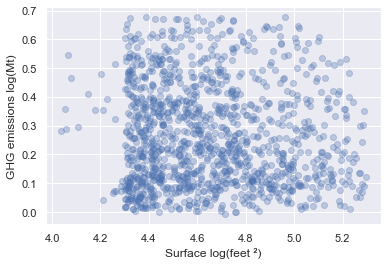

In [54]:
x = tmp_dt["PropertyGFABuilding(s)"].to_numpy()
y = tmp_dt["GHGEmissionsIntensity"].to_numpy()
plt.scatter(np.log10(x+1), np.log10(y+1), alpha = 0.3)
plt.xlabel("Surface log(feet ²)")
plt.ylabel("GHG emissions log(Mt)")
plt.savefig("./CO2/CO2_vs_Surface_log.png")

# Nouveaux data frames

In [55]:
dt = dt.loc[dt["PropertyGFABuilding(s)"]< 200000]
new_dt = dt.copy()

# Jeux d'entraînement et de test

### Features

In [56]:
#Features
data = new_dt.loc[:,['BuildingType', 'PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings', 
        'NumberofFloors', 'PropertyGFATotal', "PropertyGFAParking", "PropertyGFABuilding(s)"]]
dt_X = pd.get_dummies(data, columns = ["BuildingType", 'PrimaryPropertyType'])

In [57]:
dt_X.shape

(1237, 32)

### Target

In [58]:
#Target
dt_Y = new_dt.loc[:,["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]]

In [59]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dt_X, dt_Y, test_size=0.2, random_state=42)

Energy_test = y_test["SiteEnergyUse(kBtu)"].to_numpy().reshape(-1, 1)
CO2_test = y_test["TotalGHGEmissions"].to_numpy().reshape(-1, 1)
Energy_train = y_train["SiteEnergyUse(kBtu)"].to_numpy().reshape(-1, 1)
CO2_train = y_train["TotalGHGEmissions"].to_numpy().reshape(-1, 1)

## Distribution

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


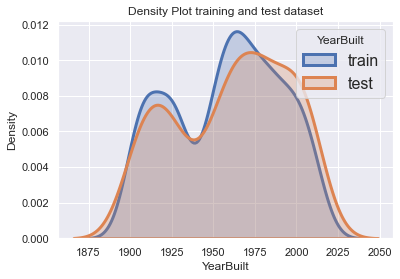

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


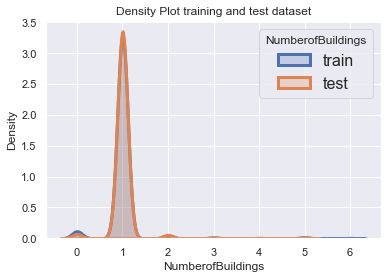

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


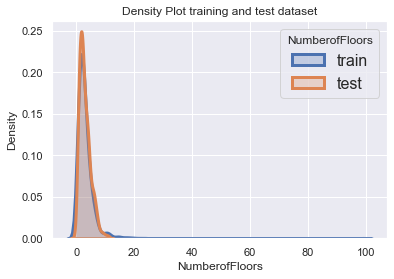

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


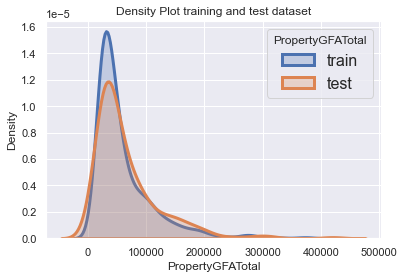

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


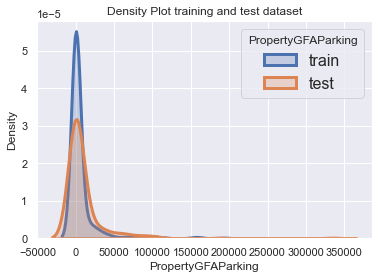

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


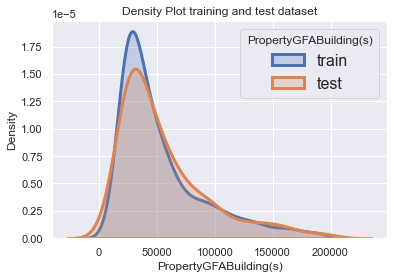

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


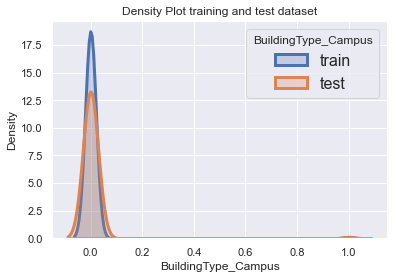

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


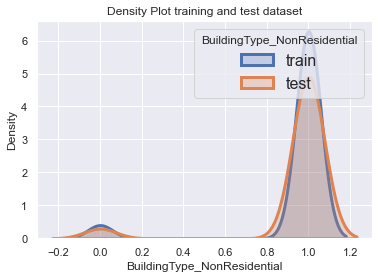

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


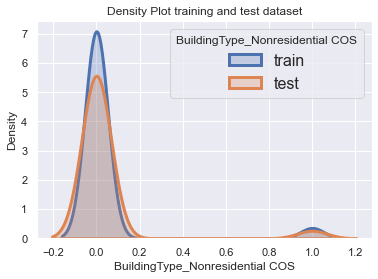

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


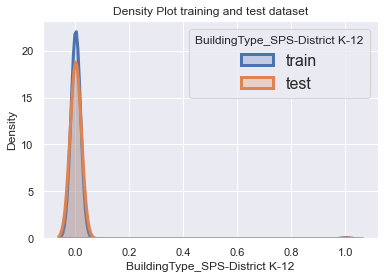

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


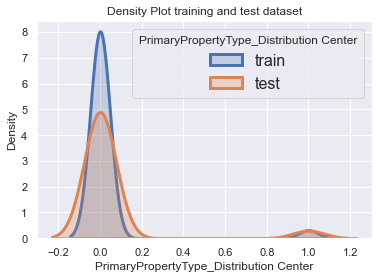

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


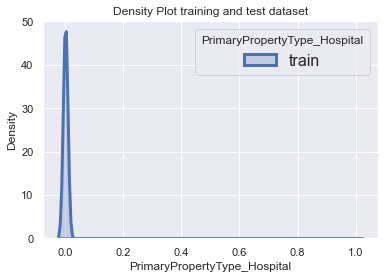

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


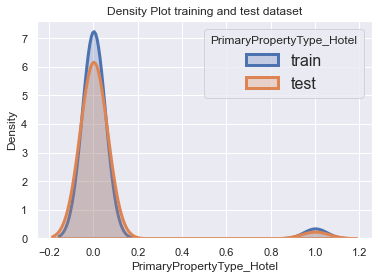

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


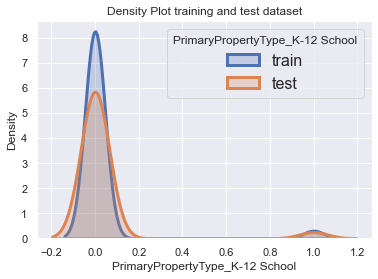

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


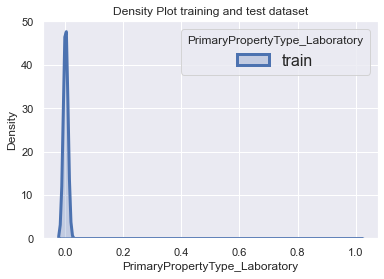

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


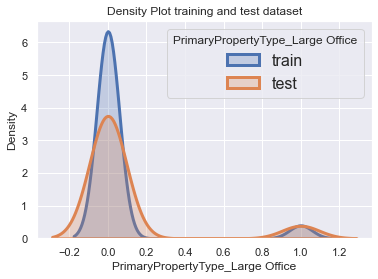

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


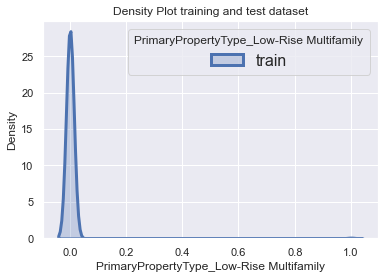

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


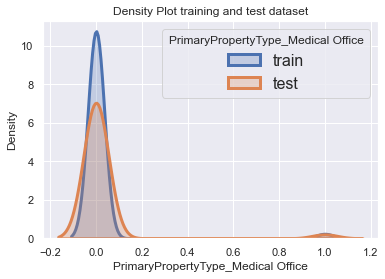

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


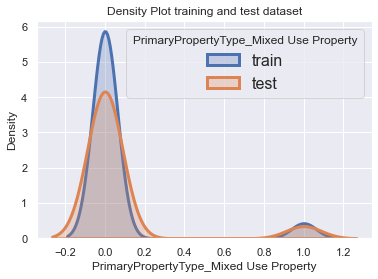

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


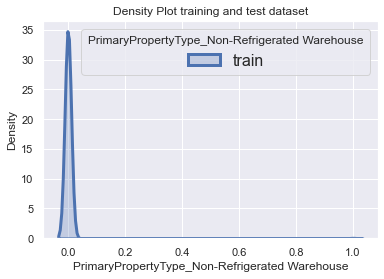

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


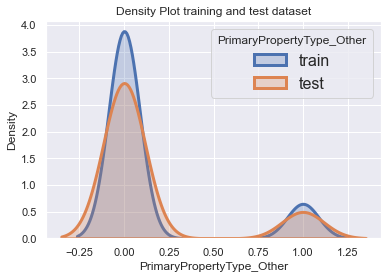

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


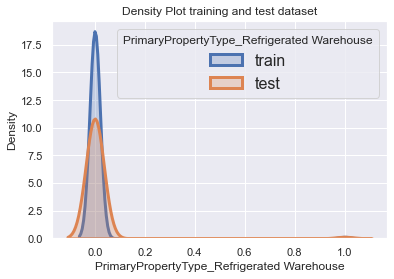

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


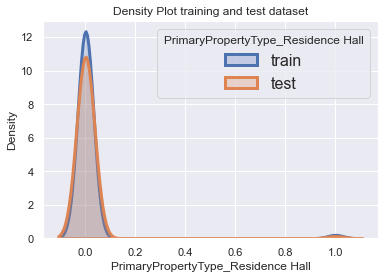

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


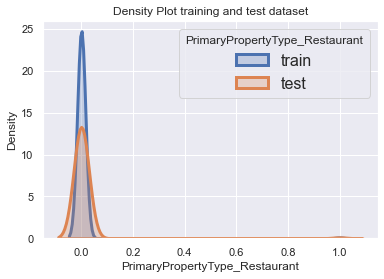

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


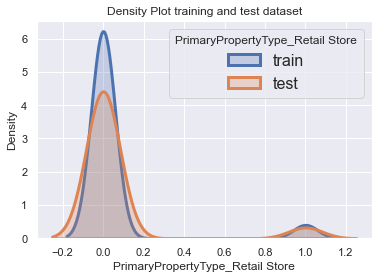

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


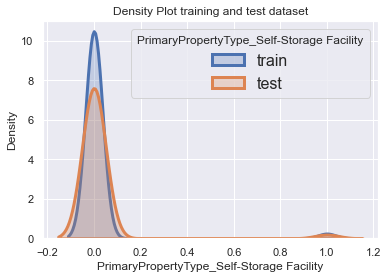

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


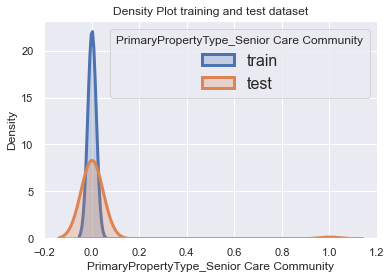

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


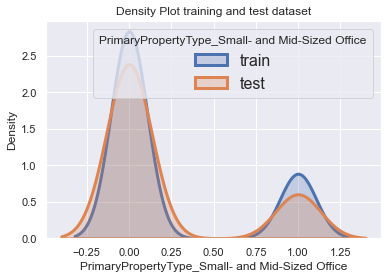

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


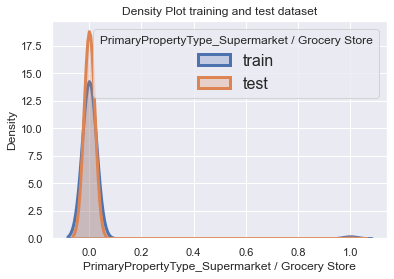

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


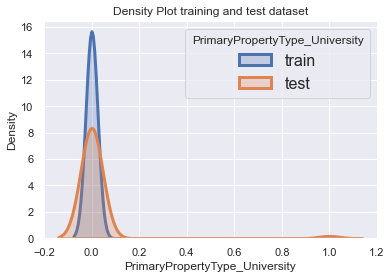

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


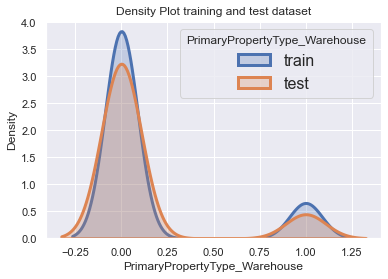

C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jayse\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


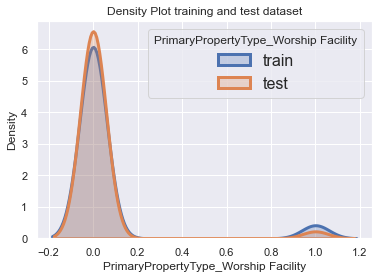

In [60]:
#On vérifie que les distributions sont similaires entre le jeux d'entraînent et de test.
cpt = 0
for col in X_train.columns:
    sns.distplot(X_train[col], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, label = "train")
    sns.distplot(X_test[col], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, label = "test")    
    # Plot formatting
    plt.legend(prop={'size': 16}, title = col)
    plt.title('Density Plot training and test dataset')
    plt.xlabel(col)

    plt.ylabel('Density')
    plt.savefig("./Distribution/denstity_"+str(cpt)+".png")
    cpt += 1 
    plt.show()

# Consommation d'énergie

# Modèle de base

In [61]:
>>> from sklearn.dummy import DummyRegressor

def DummyModel(Xtrain, Ytrain, Xtest, Ytest,  strategy = "mean"):
    """
    Generate a dummy model use as baseline
    X: dataset
    y: numpy array (target)
    strategy: model use (string )
    """
    dummy_regr = DummyRegressor(strategy="mean")
    dummy_regr.fit(Xtrain, Ytrain)
    y_dummy = dummy_regr.predict(Xtest)
    print("R²: {0:.2f}".format(dummy_regr.score(Xtest, Ytest)))
    MAE = mean_absolute_error(Ytest, y_dummy)
    print("MAE {0:.2f}".format(MAE))


In [62]:
DummyModel(X_train, Energy_train, X_test, Energy_test)

R²: -0.02
MAE 2091750.24


## Regression linéaire ridge consommation d'énergie et surface du bâtiment

In [63]:
def best_alpha(errors, alphas):
    """
    Compare errors as function of alpha coefficient
    Return alpha'value has the lowest error's value
    Arguments:
        _errors: list of list with models's error
        alphas; list of alpha's values used
    Return:
        alpha: alpha value with the lowest error
    """
    tmp = []
    for error in errors:
        tmp.append(np.min(error))
    fold = np.where(tmp == np.min(tmp))[0][0]
    ind = np.where(errors[fold] == np.min(errors[fold]))[0][0]
    return alphas[ind]

In [64]:
#On utilise une régression linéaire ridge après avoir transformé la feature
#et la target
def log_transform_regression(y, X, alpha):
    """
    Apply log transformation on X and Y. 
    Realize a linear regression (ridge) with cross validation
    Arguments:
        y: target values
        X: pandas dataframe with one feature
        alpha: coefficient for ridge linear regression
    Return:
        error: list of mean absolute error (for each model generated)
        model_reg: list with linar regression models
        datas: list countaining features, y predicted and y observed
    """
    x_scaled = np.log10(X.to_numpy())
    y_scaled = np.log10(y)
    errors = []
    model_reg = []
    datas = []
    #5 fold
    kf = KFold(n_splits=5)
    kf.get_n_splits(x_scaled)
    #cross validation
    for train_index, test_index in kf.split(x_scaled):
        x_train = x_scaled[train_index]
        y_train = y_scaled[train_index]
        x_test = x_scaled[test_index]
        y_test = y[test_index]
        regr = linear_model.Ridge()
        regr.set_params(alpha=alpha)
        regr.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
        #évaluation du model
        y_predict = 10 ** regr.predict(x_test.reshape(-1, 1))
        errors.append(mean_absolute_error(y_predict, y_test))
        model_reg.append(regr)
        #sauvegarde des données
        datas.append([x_test, y_predict, y_test])
    return errors, model_reg, datas

In [65]:
def error_alpha_ridge_2(X, Y, alphas, path = None):
    """
    Apply cross validation and plot mean absolute error 
    observed for differents alphas coefficients.
    Arguments:
        X: panda serie
        Y: numpy array
        alphas: numpy array with alpha coefficients used
        path: file name and its localization
    Return:
        alph: Alpha's value minimizes error
    """
    x_scaled = np.log10(X.to_numpy())
    y_scaled = np.log10(Y.reshape(-1, 1))
    errors = []
    #5 fold
    kf = KFold(n_splits=5)
    kf.get_n_splits(x_scaled)
    #cross validation
    cpt = 1 #number's fold (for plot)
    errors = []
    for train_index, test_index in kf.split(x_scaled):
        #training set
        x_train = x_scaled[train_index]
        y_train = y_scaled[train_index]
        #test set
        x_test = x_scaled[test_index]
        y_test = Y[test_index]
        ridge = linear_model.Ridge()
        tmp = []
        for a in alphas:
            ridge.set_params(alpha=a)
            ridge.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
            y_pred = 10 ** ridge.predict(x_test.reshape(-1, 1))
            tmp.append(mean_absolute_error(y_test, y_pred))
        errors.append(tmp)
        ax = plt.gca()
        ax.plot(alphas, tmp, label ="fold "+str(cpt))
        ax.set_xscale('log')
        plt.xlabel('alpha')
        plt.ylabel('error')
        plt.title("Mean absolute error as function of alpha")
        plt.axis('tight')
        cpt += 1
    plt.legend()
    if path is not None:
        plt.savefig(path)
    plt.show()
    alph = best_alpha(errors, alphas)
    print("Alpha optimal {0}".format(alph))
    return alph

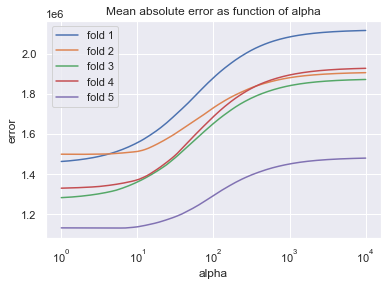

Alpha optimal 3.827494478516312


In [66]:
#Recherche du eilleur paramètre alpha
alph = error_alpha_ridge_2(X_train["PropertyGFABuilding(s)"], Energy_train, 
                  np.logspace(0, 4, 200), "Error_ridge_simple.png")

In [67]:
errors, model_ridge, datas = log_transform_regression(Energy_train, 
                                    X_train["PropertyGFABuilding(s)"], 
                                    alph)
#Meilleur modèle
best = np.where(errors == np.min(errors))[0][0]
print("Le meilleur modèle est le {0}".format(best))
print(errors[best])
mdl_ridge = model_ridge[best]

Le meilleur modèle est le 4
1129765.7287046886


L'erreur moyennen absolue du modèle: 1472661.67 kBtu
R² 0.409


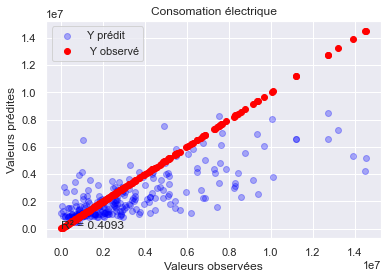

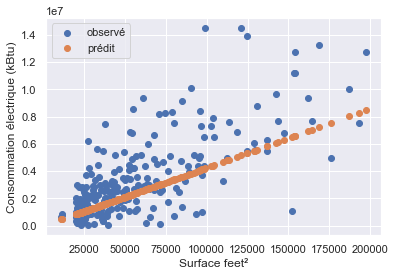

In [68]:
# datas liste de liste qui contient X, Y prédits et Y observés
y = Energy_test
x = X_test["PropertyGFABuilding(s)"]
X_scaled = np.log10(x.to_numpy())

y_pred = 10 ** model_ridge[best].predict(X_scaled.reshape(-1, 1))
print("L'erreur moyennen absolue du modèle: {0:.2f} kBtu".format(mean_absolute_error(y_pred, y)))
R2 = r2_score(y, y_pred)
print("R² {0:.3f}".format(R2))

plt.scatter(y, y_pred, label = "Y prédit", color = "blue", alpha = 0.3)
plt.scatter(y, y, label = " Y observé", color = "red")
plt.title("Consomation électrique")
plt.xlabel("Valeurs observées")
plt.ylabel("Valeurs prédites")
plt.legend()
plt.text(1, 35, "R² = {0:.4f}".format(R2))
plt.savefig("energie_ridge_simple.png")
plt.show()

plt.scatter(x, y, label="observé")
plt.scatter(x, y_pred, label ="prédit")
plt.xlabel("Surface feet²")
plt.ylabel("Consommation électrique (kBtu)")
plt.legend()
plt.show()


# Regressions linéaires multi classes

## Regression linéaire ridge

In [69]:
def select_linear_model(X, Y, fold = 5, seed = 42, normalizeX = True, normalizeY = True):
    """
    Made cross validation for linear regression.
    Arguments:
        X: Feature dataset
        Y: target dataset
        fold: Number (int) of fold
        seed: seed use for Kfold
        normalizeX: (bool) process normalization 
        normalizeY: (bool) process normalization
    Retun:
        error: list of mean absolute error (for each model generated)
        model_reg: list with linar regression models
        datas: list countaining features, y predicted and y observed
        scalerY: StandardScaler()
        scalerX: StandardScaler()
    """
    R2 = []
    errors = []
    model_reg = []
    inverseY = []
    datas = []
    #Normalize datasets
    if normalizeX:
        scalerX = StandardScaler()
        X_scaled = scalerX.fit_transform(X)
    else:
        scalerX = None
        X_scaled = X
    if normalizeY:
        scalerY = StandardScaler()
        Y_scaled = scalerY.fit_transform(Y.reshape(-1, 1))
    else:
        Y_scaled = Y.reshape(-1, 1)
        scalerY = None
    # generate kfold
    kf = KFold(n_splits=fold, random_state=seed, shuffle=True)
    kf.get_n_splits(X)
    for train_index, test_index in kf.split(X):
        x_train = X_scaled[train_index]
        y_train = Y_scaled[train_index]
        x_test = X_scaled[test_index]
        y_test = Y[test_index]
        regr = linear_model.LinearRegression()
        regr.fit(x_train, y_train)
        #model evaluation
        if normalizeY:
            y_predict = scalerY.inverse_transform(regr.predict(x_test))
        else:
            y_predict = regr.predict(x_test)
        errors.append(mean_absolute_error(y_predict, y_test))
        model_reg.append(regr)
        datas.append([X.iloc[test_index], y_predict, y_test])
    return errors, model_reg, datas, scalerY, scalerX

In [70]:
def error_alpha(data_X, data_Y, alphas, path = None, normalize = True):
    """
    Apply cross validation and plot mean absolute error 
    observed for differents alphas coefficients.
    Arguments:
        data_X: panda data frame (features)
        data_Y: numpy array (target)
        alphas: numpy array with alpha coefficients used
        path: file name and its localization
        normalize: (bool) Normalize data_X and data_Y 
    """    
    data_Y = data_Y.reshape(-1, 1)
    if normalize:
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        X_scaled = scalerX.fit_transform(data_X)
        Y_scaled = scalerY.fit_transform(data_Y)
    else:
        X_scaled = data_X
        Y_scaled = data_Y
    R2 = []
    parameters = [0,0]
    errors = []
    #On va créer 5 folds 
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X_scaled)
    cpt = 1
    for train_index, test_index in kf.split(X_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train = X_scaled[train_index]
        y_train = Y_scaled[train_index]
        x_test = X_scaled[test_index]
        y_test = data_Y[test_index]
        ridge = linear_model.Ridge()
        errors = []
        for a in alphas:
            ridge.set_params(alpha=a)
            ridge.fit(X_train, y_train)
            #MAE
            y_pred = scalerY.inverse_transform(ridge.predict(x_test))
            errors.append(mean_absolute_error(y_test, y_pred))
        ax = plt.gca()
        ax.plot(alphas, errors, label ="fold "+str(cpt))
        ax.set_xscale('log')
        plt.xlabel('log alpha')
        plt.ylabel('error')
        plt.title("Mean absolute error as function of alpha")
        plt.axis('tight')
        cpt += 1
    if path is not None:
        plt.savefig(path)
    plt.legend()
    plt.show()

In [71]:
def kfold_process_ridge(X, Y, alpha, fold=5, seed=42, normalize = True):
    """
    Apply ridge regression on kfold.
    Arguments:
        X: panda data frame (features)
        Y: numpy array (target)
        alpha: alpha coefficient used
        fold: number of fold use
        seed: randoom seed (int)
        normalize: (bool) Normalize X and Y 
    Retun:
        error: list of mean absolute error (for each model generated)
        model_ridge: list with linar regression models
        datas: list countaining features, y predicted and y observed
        scalerY: StandardScaler()
        scalerX: StandardScaler()
    """
    scalerX = StandardScaler()
    X_scaled = scalerX.fit_transform(X)
    if normalize:
        scalerY = StandardScaler()
        Y_scaled = scalerY.fit_transform(Y.reshape(-1, 1))
    else:
        Y_scaled = Y.reshape(-1, 1)
        scalerY = None
    R2 = []
    errors = []
    model_ridge = []
    datas = []
    #création des folds
    kf = KFold(n_splits=fold, random_state=seed, shuffle=True)
    kf.get_n_splits(X)
    for train_index, test_index in kf.split(X):
        #divide dataset
        X_train = X_scaled[train_index]
        y_train = Y_scaled[train_index]
        x_test = X_scaled[test_index]
        y_test = Y[test_index]
        ridge = linear_model.Ridge()
        ridge.set_params(alpha=alpha)
        ridge.fit(X_train, y_train)
        if normalize:
            y_predict = scalerY.inverse_transform(ridge.predict(x_test))
        else:
            y_predict = ridge.predict(x_test)
        errors.append(mean_absolute_error(y_test, y_predict))
        model_ridge.append(ridge)
        R2.append(r2_score(y_test, y_predict))
        datas.append([X.iloc[test_index], y_predict, y_test])
    return errors, model_ridge, datas, scalerY, scalerX

### Recherche par grille

In [72]:
#On cherche le paramètre alpha pour la régression ridge
scalerX = StandardScaler()
scalerY = StandardScaler()
X_scaled = scalerX.fit_transform(X_train)
#data_Y = Energy_train.reshape(-1, 1)
#Y_scaled = scalerY.fit_transform(data_Y)

# prepare a range of alpha values to test
alphas = np.logspace(-5, 5, 200)
# create and fit a ridge regression model, testing each alpha
grid = GridSearchCV(estimator=Ridge(), param_grid=dict(alpha=alphas), refit = True, 
                    cv=5, scoring = 'neg_root_mean_squared_error')
grid.fit(X_scaled, Energy_train)
#print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

-1792673.6838714734
172.25859653987874


On modélise l'erreur pour les différents folds avec les différents valeurs de coefficient de régularisation

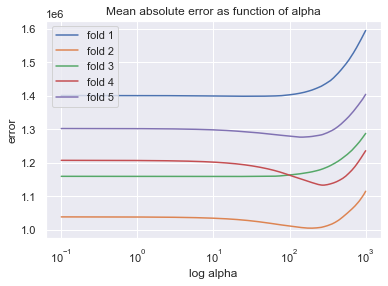

In [73]:
error_alpha(X_train, Energy_train, np.logspace(-1, 3, 200), "energie_erreur_alpha_ridge.png") 

In [74]:
errors_train, model_reg, datas, scalerY , scalerX= kfold_process_ridge(X_train, Energy_train, grid.best_estimator_.alpha,
                                                              fold = 5, seed = 99, normalize = True)
print(errors_train)
print("Meilleur modèle n°{0}".format(np.where(errors_train == np.min(errors_train))[0][0]+1))
best = np.where(errors_train == np.min(errors_train))[0][0]

[1299439.4376132262, 1215831.7369083525, 1306630.2349947237, 1032420.9685503393, 1122816.335135355]
Meilleur modèle n°4


### Evaluation des modèles avec les jeux de test

L'erreur moyennen absolue du modèle: 1227935.95 kBtu
R² 0.6240


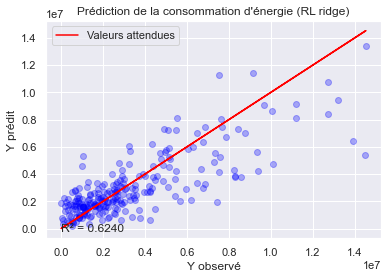

In [75]:
#all_prediction_vs_observation(datas, "PropertyGFABuilding(s)")
plot_pred_vs_obser(X_test, Energy_test, model_reg[best], "Prédiction de la consommation d'énergie (RL ridge)", scalerX , scalerY)

L'erreur moyenne absolue est de 1211002.73 kBtu pour le jeu de test contre pour le jeu d'entrînement 1027918.13.
 * Pas de surpprentissage
 * Estmation mauvaise pour des bâtiments consommant plus de 5 000 000 kBtu 

## Regression lasso

### Recherche des hyperparamètres

In [76]:
def check_hyperparameters_lasso(X, Y, alphas):
    """
    Process a grid search to find optimal alpha
    Arguments:
        _X dataframe (features)
        _Y numpy array (target)
        _alphas: numpy array with alpha values
    Return:
        grid: scikit lean object
    """
    #Normalize dataset
    scalerX = StandardScaler()
    scalerY = StandardScaler()
    X_scaled = scalerX.fit_transform(X)
    data_Y = Y.reshape(-1, 1)
    Y_scaled = scalerY.fit_transform(data_Y)
    # create and fit a ridge regression model, testing each alpha
    grid = GridSearchCV(linear_model.Lasso(max_iter = 100000), param_grid=dict(alpha=alphas),
                       refit = True, cv=5, scoring = 'neg_root_mean_squared_error')
    grid.fit(X_scaled, np.ravel(Y_scaled))
    # summarize the results of the grid search
    #print(grid.best_score_)
    print(grid.best_estimator_.alpha)    
    return grid

In [77]:
def error_alpha_lasso(data_X, data_Y, alphas, path = None, normalize = True):
    """
    Apply cross validation and plot mean absolute error 
    observed for differents alphas coefficients.
    Arguments:
        data_X: panda data frame (features)
        data_Y: numpy array (target)
        alphas: numpy array with alpha coefficients used
        path: file name and its localization
        normalize: (bool) Normalize data_X and data_Y 
    """ 
    data_Y = data_Y.reshape(-1, 1)
    if normalize:
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        X_scaled = scalerX.fit_transform(data_X)
        Y_scaled = scalerY.fit_transform(data_Y)
    else:
        X_scaled = data_X
        Y_scaled = data_Y
    #On va créer 5 folds 
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X_scaled)
    cpt = 1
    for train_index, test_index in kf.split(X_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train = X_scaled[train_index]
        y_train = Y_scaled[train_index]
        x_test = X_scaled[test_index]
        y_test = data_Y[test_index]
        lasso = linear_model.Lasso()
        coefs = []
        errors = []
        for a in alphas:
            lasso.set_params(alpha=a, max_iter = 500000)
            lasso.fit(X_train, y_train)
            #MAE
            if normalize:
                y_pred = scalerY.inverse_transform(lasso.predict(x_test))
            else:
                y_pred = lasso.predict(x_test)
            errors.append(mean_absolute_error(y_test, y_pred))
        ax = plt.gca()
        ax.plot(alphas, errors, label ="fold "+str(cpt))
        ax.set_xscale('log')
        plt.xlabel('log alpha')
        plt.ylabel('error')
        plt.title("Mean absolute error as function of alpha")
        plt.axis('tight')
        cpt += 1
    plt.legend()
    if path is not None:
        plt.savefig(path)
    plt.show()

In [78]:
def kfold_process_lasso(X, Y, alpha, fold=5, seed=42, normalize = True):
    """
    Apply ridge lasso on kfold.
    Arguments:
        X: panda data frame (features)
        Y: numpy array (target)
        alpha: alpha coefficient used
        fold: number of fold use
        seed: randoom seed (int)
        normalize: (bool) Normalize X and Y 
    Retun:
        error: list of mean absolute error (for each model generated)
        model_lasso: list with linar regression models
        datas: list countaining features, y predicted and y observed
        scalerY: StandardScaler()
        scalerX: StandardScaler()
    """
    data_Y = Y.reshape(-1, 1)
    if normalize:
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        X_scaled = scalerX.fit_transform(X)
        Y_scaled = scalerY.fit_transform(data_Y)
    else:
        X_scaled = X
        Y_scaled = data_Y
    R2 = []
    coefs = []
    errors = []
    datas = []
    model_lasso = []
    #création des folds
    kf = KFold(n_splits=fold, random_state=seed, shuffle=True)
    kf.get_n_splits(X_scaled)
    for train_index, test_index in kf.split(X_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train = X_scaled[train_index]
        y_train = Y_scaled[train_index]
        x_test = X_scaled[test_index]
        y_test = data_Y[test_index]
        model = linear_model.Lasso(alpha=alpha, max_iter= 100000)
        model.fit(X_train, y_train)
        if normalize:
            y_predict = scalerY.inverse_transform(model.predict(x_test))
        else:
            y_predict = model.predict(x_test)
        errors.append(mean_absolute_error(y_test, y_predict))
        R2.append(r2_score(y_test, y_predict))
        datas.append([X.iloc[test_index], y_predict, y_test])
        model_lasso.append(model)
    #print(model.sparse_coef_)
    return errors, model_lasso, datas, scalerY, scalerX

In [79]:
grid = check_hyperparameters_lasso(X_train, Energy_train, np.logspace(-5, 5, 100))

0.021544346900318846


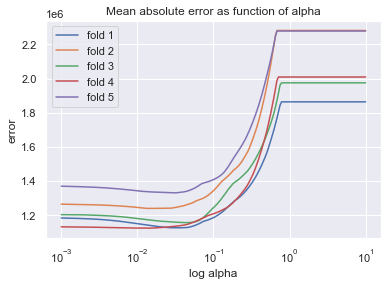

In [80]:
error_alpha_lasso(X_train, Energy_train, np.logspace(-3, 1, 200), "energie_erreur_alpha_lasso_raw.png")

In [81]:
errors_train, model_lasso, datas, scalerY, scalerX = kfold_process_lasso(X_train, Energy_train, grid.best_estimator_.alpha,
                                                              fold=5, seed=42)

In [82]:
print(errors_train)
print("Meilleur modèle: {0}".format(np.where(errors_train == np.min(errors_train))[0][0]))
best = np.where(errors_train == np.min(errors_train))[0][0]

[1082826.8791109126, 1304397.9112590554, 1130813.3720423526, 1321656.0699681893, 1152096.440264025]
Meilleur modèle: 0


In [83]:
model_lasso[best].coef_

array([ 0.05704398,  0.03659088,  0.10263699,  0.29308555,  0.        ,
        0.34323932,  0.01633645, -0.00755327,  0.02185947, -0.        ,
       -0.04551693, -0.        ,  0.11679438, -0.01799463,  0.04485882,
        0.        , -0.00059275,  0.03747765,  0.        , -0.        ,
        0.02125178,  0.        , -0.        ,  0.        ,  0.01665914,
       -0.08204088, -0.        , -0.        ,  0.16471218, -0.        ,
       -0.1552422 , -0.03824733])

# Simplification du jeux d'entraînement et de test

Plusieurs variables ont un coefficient valant 0.

In [84]:
print(dt_X.columns[np.where(model_lasso[best].coef_ == 0)[0]].values)
col2remove = dt_X.columns[np.where(model_lasso[best].coef_ == 0)[0]].values
print("Features à retirer")
new_dtX = dt_X.drop(col2remove, axis=1)

['PropertyGFAParking' 'BuildingType_SPS-District K-12'
 'PrimaryPropertyType_Hospital' 'PrimaryPropertyType_Large Office'
 'PrimaryPropertyType_Mixed Use Property'
 'PrimaryPropertyType_Non-Refrigerated Warehouse'
 'PrimaryPropertyType_Refrigerated Warehouse'
 'PrimaryPropertyType_Residence Hall' 'PrimaryPropertyType_Restaurant'
 'PrimaryPropertyType_Senior Care Community'
 'PrimaryPropertyType_Small- and Mid-Sized Office'
 'PrimaryPropertyType_University']
Features à retirer


In [85]:
new_dtX.shape

(1237, 20)

In [86]:
#Target
dt_Y = new_dt.loc[:,["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]]

In [87]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(new_dtX, dt_Y, test_size=0.2, random_state=42)

Elec_test = y_test.iloc[:,0].to_numpy().reshape(-1, 1)
CO2_test = y_test.iloc[:,1].to_numpy().reshape(-1, 1)
Energy_train = y_train.iloc[:,0].to_numpy().reshape(-1, 1)
CO2_train = y_train.iloc[:,1].to_numpy().reshape(-1, 1)

# Nouveau modèle

In [88]:
grid = check_hyperparameters_lasso(X_train, Energy_train, np.logspace(-5, 5, 100))

0.021544346900318846


In [89]:
errors_train, model_lasso, datas, scalerY, scalerX = kfold_process_lasso(X_train, Energy_train, grid.best_estimator_.alpha,
                                                              fold=5, seed=42)

In [90]:
print(errors_train)
print("Meilleur modèle: {0}".format(np.where(errors_train == np.min(errors_train))[0][0]))
best = np.where(errors_train == np.min(errors_train))[0][0]

[1082827.0941139965, 1305916.6258001411, 1131311.3671614775, 1318738.989594433, 1142683.6914154224]
Meilleur modèle: 0


In [91]:
model_lasso[best].coef_

array([ 0.05704494,  0.03659078,  0.10263792,  0.29308044,  0.34324362,
        0.0163388 , -0.00754664,  0.02186524, -0.04551702,  0.11679414,
       -0.01799422,  0.04485889, -0.00059272,  0.03747801,  0.021252  ,
        0.01665901, -0.08204099,  0.16471199, -0.15524239, -0.03824732])

L'erreur moyennen absolue du modèle: 1220644.75 kBtu
R² 0.6292


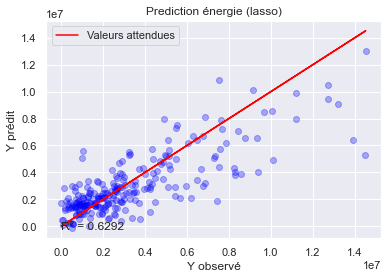

In [92]:
plot_pred_vs_obser(X_test, Energy_test, model_lasso[best], "Prediction énergie (lasso)", scalerX , scalerY)

## Regression elastic net

In [93]:
def kfold_process_ElasticNet(X, Y, alpha, l1_ratio, fold=5, seed=42, normalize = True):
    """
    Apply ridge Elastic Net on kfold.
    Arguments:
        X: panda data frame (features)
        Y: numpy array (target)
        alpha: alpha coefficient used
        fold: number of fold use
        seed: randoom seed (int)
        normalize: (bool) Normalize X and Y 
    Retun:
        error: list of mean absolute error (for each model generated)
        model: list with linar regression models
        datas: list countaining features, y predicted and y observed
        scalerY: StandardScaler()
        scalerX: StandardScaler()
    """
    data_Y = Y.reshape(-1, 1)
    if normalize:
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        X_scaled = scalerX.fit_transform(X)
        Y_scaled = scalerY.fit_transform(data_Y)
    else:
        X_scaled = X
        Y_scaled = data_Y
    R2 = []
    errors = []
    datas = []
    mdl_elastic = []
    #création des folds
    kf = KFold(n_splits=fold, random_state=seed, shuffle=True)
    kf.get_n_splits(X_scaled)
    for train_index, test_index in kf.split(X_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train = X_scaled[train_index]
        y_train = Y_scaled[train_index]
        x_test = X_scaled[test_index]
        y_test = data_Y[test_index]
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter= 100000)
        model.fit(X_train, y_train)
        if normalize:
            y_predict = scalerY.inverse_transform(model.predict(x_test))
        else:
            y_predict = model.predict(x_test)
        mdl_elastic.append(model)
        errors.append(mean_absolute_error(y_test, y_predict))
        R2.append(r2_score(y_test, y_predict))
        datas.append([X.iloc[test_index], y_predict, y_test])
    #print(model.sparse_coef_)
    return errors, mdl_elastic, datas, scalerY, scalerX

Deux objectifs:
   * Identifier des variables corrélées
   * Amélioer les prédictions

### Recherche des hyperparamètres

In [94]:
def check_hyperparameters_elastic(X, Y, alphas):
    """
    Process a grid search to find optimal alpha
    Arguments:
        _X dataframe (features)
        _Y numpy array (target)
        _alphas: numpy array with alpha values
    Return:
        grid: scikit lean object
    """
    #Normalize dataset
    scalerX = StandardScaler()
    scalerY = StandardScaler()
    X_scaled = scalerX.fit_transform(X)
    data_Y = Y.reshape(-1, 1)
    Y_scaled = scalerY.fit_transform(data_Y)
    # create and fit a ridge regression model, testing each alpha
    grid = ElasticNetCV(alphas=alphas, cv=5, max_iter=50000)
    grid.fit(X_scaled, np.ravel(Y_scaled))
    return grid

In [95]:
def error_alpha_elastic(data_X, data_Y, alphas, l1, normalize = True):
    """
    Compute error as function of alpha's values
    Arguments:
        _data_X: features dataframe 
        _data_Y: target numpy array
        _alphas: numpy array with alpha's values
        _l1: ratio l1/l2
        _normalize: (bool) 
    """
    data_Y = data_Y.reshape(-1, 1)
    if normalize:
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        X_scaled = scalerX.fit_transform(data_X)
        Y_scaled = scalerY.fit_transform(data_Y)
    else:
        X_scaled = data_X
        Y_scaled = data_Y
    errors = []
    #On va créer 5 folds 
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X_scaled)
    cpt = 1
    for train_index, test_index in kf.split(X_scaled):
        X_train = X_scaled[train_index]
        y_train = Y_scaled[train_index]
        x_test = X_scaled[test_index]
        y_test = data_Y[test_index]
        errors = []
        for a in alphas:
            model = ElasticNet(alpha=a, l1_ratio=l1, max_iter= 100000)
            model.fit(X_train, y_train)
            if normalize:
                y_pred = scalerY.inverse_transform(model.predict(x_test))
            else:
                y_pred = model.predict(x_test)
            #MAE
            errors.append(mean_absolute_error(y_test, y_pred))
        ax = plt.gca()
        ax.plot(alphas, errors, label ="fold "+str(cpt))
        ax.set_xscale('log')
        plt.xlabel('log alpha')
        plt.ylabel('error')
        plt.title("Mean absolute error as function of alpha")
        plt.axis('tight')
        cpt += 1
    plt.legend()
    plt.show()

In [96]:
grid = check_hyperparameters_elastic(X_train, Energy_train, np.logspace(-5, 5, 200))
print(grid.l1_ratio_)
#Alpha
print(grid.alpha_)

0.5
0.036969127071950283


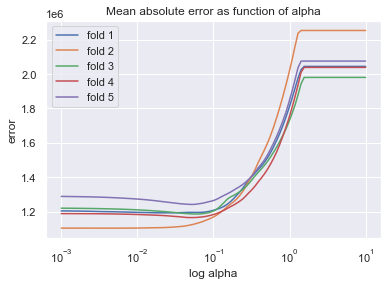

In [361]:
error_alpha_elastic(X_train, Energy_train, np.logspace(-3, 1, 100), grid.l1_ratio_)

In [362]:
errors_train, model_elastic, datas, scalerY, scalerX = kfold_process_ElasticNet(X_train, Energy_train, grid.alpha_, 
                                                                   grid.l1_ratio_, fold=5, seed=42)

les coeficients ont des valeurs différentes. Les variables ne sont pas corrélées. 

In [363]:
print(errors_train)
print("Meilleur modèle: {0}".format(np.where(errors_train == np.min(errors_train))[0][0]))
best = np.where(errors_train == np.min(errors_train))[0][0]

[1089143.118297802, 1302175.5168693908, 1134399.5089759042, 1313913.8380140238, 1139262.073652737]
Meilleur modèle: 0


In [364]:
model_elastic[best].coef_

array([ 0.05920669,  0.0384405 ,  0.11082935,  0.2920995 ,  0.33755317,
        0.02013354, -0.00629869,  0.02514135, -0.04696613,  0.11726435,
       -0.02013609,  0.04659335, -0.00371716,  0.04012955,  0.02298963,
        0.0202568 , -0.08327091,  0.1650844 , -0.15399316, -0.04029073])

les coeficients ont des valeurs différentes. Les variables ne sont pas corrélées. 

L'erreur moyennen absolue du modèle: 1221447.27 kBtu
R² 0.6300


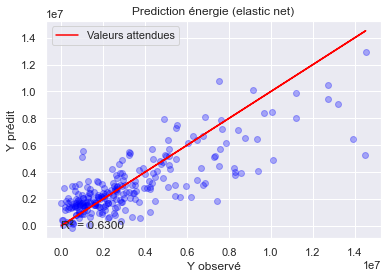

In [365]:
plot_pred_vs_obser(X_test, Energy_test, model_elastic[best], "Prediction énergie (elastic net)", scalerX , scalerY)

### Conclusion regressions linéaires

Le meilleur modèle créé utilise la **régression liniaire Elastic Net** avec un **R² de 0.6317** et une erreur moyenne de **1 214 368 kBtu**. Le modèle a tendence a sous-estimé la consommation d'énergie (bâtiments consommant plus de 6 millions de kBtu).

In [366]:
new_data = dt.loc[:,['BuildingType', 'PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings', 
        'NumberofFloors', 'PropertyGFATotal', "PropertyGFAParking", 
        "PropertyGFABuilding(s)", "SiteEnergyUse(kBtu)", "TotalGHGEmissions"]]
new_data = pd.get_dummies(new_data, columns = ["BuildingType", 'PrimaryPropertyType'])
new_data = new_data.drop(col2remove, axis=1)

In [367]:
new_data.to_csv("dataset_light.csv", index =False)

# Emission de CO2

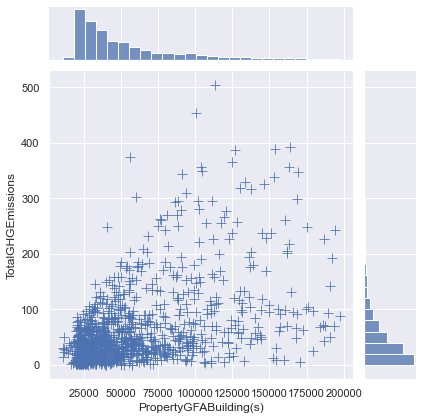

In [368]:
sns.set(font_scale=1)
scatter_plot(dt, "PropertyGFABuilding(s)", "TotalGHGEmissions", "")

Passage au logarithme pour étendre la représentation.

Text(0, 0.5, 'GHG emissions log(Mt)')

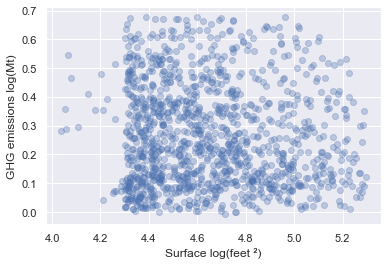

In [369]:
x = tmp_dt["PropertyGFABuilding(s)"].to_numpy()
y = tmp_dt["GHGEmissionsIntensity"].to_numpy()
plt.scatter(np.log10(x+1), np.log10(y+1), alpha = 0.3)
plt.xlabel("Surface log(feet ²)")
plt.ylabel("GHG emissions log(Mt)")

Il n'y a pas de relation linéaire entre la surface et l'émission de gaz à effet de serre.

# Nouveaux data frames

In [370]:
dt = dt.loc[dt["PropertyGFABuilding(s)"]< 200000]
new_dt = dt.copy()

# Jeux d'entraînement et de test

### Features

In [371]:
#Features
data = new_dt.loc[:,['BuildingType', 'PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings', 
        'NumberofFloors', 'PropertyGFATotal', "PropertyGFAParking", "PropertyGFABuilding(s)"]]
dt_X = pd.get_dummies(data, columns = ["BuildingType", 'PrimaryPropertyType'])

### Target

In [372]:
#Target
dt_Y = new_dt.loc[:,["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]]

In [373]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dt_X, dt_Y, test_size=0.2, random_state=42)

Energy_test = y_test["SiteEnergyUse(kBtu)"].to_numpy().reshape(-1, 1)
CO2_test = y_test["TotalGHGEmissions"].to_numpy().reshape(-1, 1)
Energy_train = y_train["SiteEnergyUse(kBtu)"].to_numpy().reshape(-1, 1)
CO2_train = y_train["TotalGHGEmissions"].to_numpy().reshape(-1, 1)

# Dummy model

In [374]:
DummyModel(X_train, CO2_train, X_test, CO2_test)

R²: -0.00
MAE 43.02


## Regression linéaire consommation d'énergie et surface du bâtiment

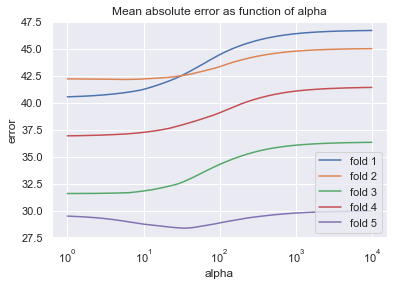

Alpha optimal 35.2970730273065


In [375]:
#Recherche du eilleur paramètre alpha
alph = error_alpha_ridge_2(X_train["PropertyGFABuilding(s)"], CO2_train+1, 
                  np.logspace(0, 4, 200), "Error_ridge_simple.png")

In [376]:
errors, model_ridge, datas = log_transform_regression(CO2_train+1, 
                                    X_train["PropertyGFABuilding(s)"], 
                                    alph)
#Meilleur modèle
best = np.where(errors == np.min(errors))[0][0]
print("Le meilleur modèle est le {0}".format(best))
print(errors[best])
mdl_ridge = model_ridge[best]

Le meilleur modèle est le 4
28.365348616298444


L'erreur moyennen absolue du modèle: 37.92 kBtu
R² 0.026


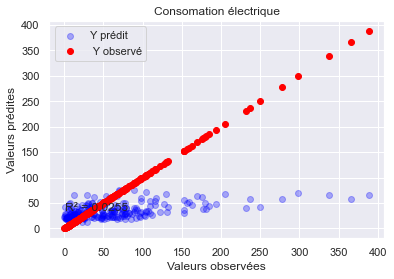

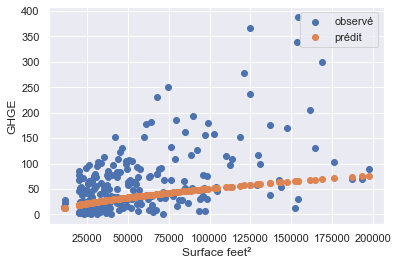

In [377]:
# datas liste de liste qui contient X, Y prédits et Y observés
y = CO2_test
x = X_test["PropertyGFABuilding(s)"]
X_scaled = np.log10(x.to_numpy())


y_pred = 10 ** model_ridge[best].predict(X_scaled.reshape(-1, 1)) -1


print("L'erreur moyennen absolue du modèle: {0:.2f} kBtu".format(mean_absolute_error(y_pred, y)))
R2 = r2_score(y, y_pred)
print("R² {0:.3f}".format(R2))

plt.scatter(y, y_pred, label = "Y prédit", color = "blue", alpha = 0.3)
plt.scatter(y, y, label = " Y observé", color = "red")
plt.title("Consomation électrique")
plt.xlabel("Valeurs observées")
plt.ylabel("Valeurs prédites")
plt.legend()
plt.text(1, 35, "R² = {0:.4f}".format(R2))
plt.savefig("energie_ridge_simple.png")
plt.show()

plt.scatter(x, y, label="observé")
plt.scatter(x, y_pred, label ="prédit")
plt.xlabel("Surface feet²")
plt.ylabel("GHGE")
plt.legend()
plt.show()


# Regressions linéaires multi classes

## Regression linéaire ridge

### Recherche par grille

In [378]:
#On cherche le paramètre alpha pour la régression ridge
scalerX = StandardScaler()
scalerY = StandardScaler()
X_scaled = scalerX.fit_transform(X_train)
#data_Y = Energy_train.reshape(-1, 1)
#Y_scaled = scalerY.fit_transform(data_Y)

# prepare a range of alpha values to test
alphas = np.logspace(-5, 5, 200)
# create and fit a ridge regression model, testing each alpha
grid = GridSearchCV(estimator=Ridge(), param_grid=dict(alpha=alphas), refit = True, 
                    cv=5, scoring = 'neg_root_mean_squared_error')
grid.fit(X_scaled, CO2_train)
#print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

-54.21592401361821
243.74441501222216


On modélise l'erreur pour les différents folds avec les différents valeurs de coefficient de régularisation

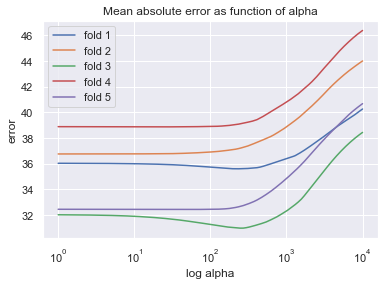

In [379]:
error_alpha(X_train, CO2_train, np.logspace(0, 4, 200), "energie_erreur_alpha_ridge.png") 

In [380]:
errors_train, model_reg, datas, scalerY , scalerX= kfold_process_ridge(X_train, CO2_train, grid.best_estimator_.alpha,
                                                              fold = 5, seed = 99, normalize = True)
print(errors_train)
print("Meilleur modèle n°{0}".format(np.where(errors_train == np.min(errors_train))[0][0]+1))
best = np.where(errors_train == np.min(errors_train))[0][0]

[36.073447254166794, 39.05073089239609, 36.53779444289471, 31.763653636000978, 34.28820726088578]
Meilleur modèle n°4


### Evaluation des modèles avec les jeux de test

L'erreur moyennen absolue du modèle: 34.50 kBtu
R² 0.3941


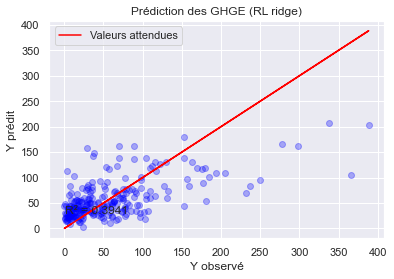

In [381]:
#all_prediction_vs_observation(datas, "PropertyGFABuilding(s)")
plot_pred_vs_obser(X_test, CO2_test, model_reg[best], "Prédiction des GHGE (RL ridge)", scalerX , scalerY)

## Regression lasso

### Recherche des hyperparamètres

In [382]:
grid = check_hyperparameters_lasso(X_train, CO2_train, np.logspace(-5, 5, 100))

0.05462277217684343


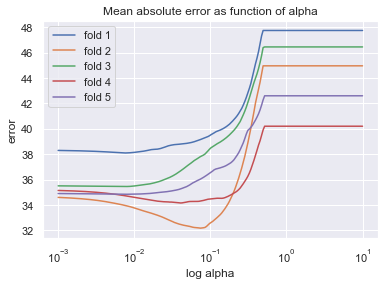

In [383]:
error_alpha_lasso(X_train, CO2_train, np.logspace(-3, 1, 200), "CO2_erreur_alpha_lasso_raw.png")

In [384]:
errors_train, model_lasso, datas, scalerY, scalerX = kfold_process_lasso(X_train, CO2_train, grid.best_estimator_.alpha,
                                                              fold=5, seed=42)

In [385]:
print(errors_train)
print("Meilleur modèle: {0}".format(np.where(errors_train == np.min(errors_train))[0][0]))
best = np.where(errors_train == np.min(errors_train))[0][0]

[33.6746613171901, 41.68981036056847, 36.13952984372127, 34.635341000415096, 33.26094267191905]
Meilleur modèle: 4


In [386]:
model_lasso[best].coef_

array([-0.        ,  0.01873886,  0.        ,  0.        , -0.        ,
        0.42644073,  0.        , -0.02900512,  0.01605709,  0.        ,
       -0.00433698, -0.        ,  0.28442223,  0.01868931,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.05153757, -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.01064688, -0.        ,  0.01349851,  0.        ,
       -0.04578439,  0.        ])

# Simplification du jeux d'entraînement et de test

Plusieurs variables ont un coefficient valant 0.

In [387]:
print(dt_X.columns[np.where(model_lasso[best].coef_ == 0)[0]].values)
col2remove = dt_X.columns[np.where(model_lasso[best].coef_ == 0)[0]].values
print("Features à retirer")
new_dtX = dt_X.drop(col2remove, axis=1)

['YearBuilt' 'NumberofFloors' 'PropertyGFATotal' 'PropertyGFAParking'
 'BuildingType_Campus' 'BuildingType_SPS-District K-12'
 'PrimaryPropertyType_Hospital' 'PrimaryPropertyType_Laboratory'
 'PrimaryPropertyType_Large Office'
 'PrimaryPropertyType_Low-Rise Multifamily'
 'PrimaryPropertyType_Medical Office'
 'PrimaryPropertyType_Mixed Use Property'
 'PrimaryPropertyType_Non-Refrigerated Warehouse'
 'PrimaryPropertyType_Refrigerated Warehouse'
 'PrimaryPropertyType_Residence Hall' 'PrimaryPropertyType_Restaurant'
 'PrimaryPropertyType_Retail Store'
 'PrimaryPropertyType_Self-Storage Facility'
 'PrimaryPropertyType_Small- and Mid-Sized Office'
 'PrimaryPropertyType_University' 'PrimaryPropertyType_Worship Facility']
Features à retirer


In [388]:
col2removelen(col2remove)

NameError: name 'col2removelen' is not defined

In [117]:
#Target
dt_Y = new_dt.loc[:,["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]]

In [118]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(new_dtX, dt_Y, test_size=0.2, random_state=42)

Elec_test = y_test.iloc[:,0].to_numpy().reshape(-1, 1)
CO2_test = y_test.iloc[:,1].to_numpy().reshape(-1, 1)
Energy_train = y_train.iloc[:,0].to_numpy().reshape(-1, 1)
CO2_train = y_train.iloc[:,1].to_numpy().reshape(-1, 1)

# Nouveau modèle

In [119]:
grid = check_hyperparameters_lasso(X_train, CO2_train, np.logspace(-4, 0, 100))

0.002364489412645407


In [120]:
errors_train, model_lasso, datas, scalerY, scalerX = kfold_process_lasso(X_train, CO2_train, grid.best_estimator_.alpha,
                                                              fold=5, seed=42)

In [121]:
print(errors_train)
print("Meilleur modèle: {0}".format(np.where(errors_train == np.min(errors_train))[0][0]))
best = np.where(errors_train == np.min(errors_train))[0][0]

[33.583362989973125, 41.149947518747965, 34.320427819526294, 34.64434164549156, 33.69363689666959]
Meilleur modèle: 0


In [122]:
model_lasso[best].coef_

array([ 0.0751746 ,  0.44181172, -0.06027116,  0.02441431, -0.02962754,
        0.41824374,  0.06363513,  0.06320866,  0.02569418,  0.07774435,
       -0.09665018])

L'erreur moyennen absolue du modèle: 36.44 kBtu
R² 0.3420


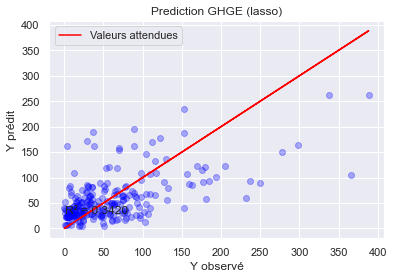

In [123]:
plot_pred_vs_obser(X_test, CO2_test, model_lasso[best], "Prediction GHGE (lasso)", scalerX , scalerY)

## Regression elastic net

### Recherche des hyperparamètres

In [124]:
grid = check_hyperparameters_elastic(X_train, CO2_train, np.logspace(-3, 0, 200))
print(grid.l1_ratio_)
#Alpha
print(grid.alpha_)

0.5
0.00429700470432084


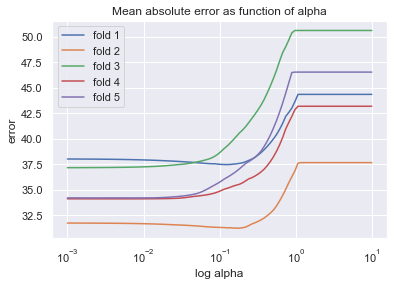

In [125]:
error_alpha_elastic(X_train, CO2_train, np.logspace(-3, 1, 100), grid.l1_ratio_)

In [126]:
errors_train, model_elastic, datas, scalerY, scalerX = kfold_process_ElasticNet(X_train, CO2_train, grid.alpha_, 
                                                                   grid.l1_ratio_, fold=5, seed=42)

les coeficients ont des valeurs différentes. Les variables ne sont pas corrélées. 

In [127]:
print(errors_train)
print("Meilleur modèle: {0}".format(np.where(errors_train == np.min(errors_train))[0][0]))
best = np.where(errors_train == np.min(errors_train))[0][0]

[33.57425005971322, 41.16227914736872, 34.31440156083115, 34.63960278018103, 33.68805896807094]
Meilleur modèle: 0


In [128]:
model_elastic[best].coef_

array([ 0.07529456,  0.44120749, -0.060013  ,  0.02475958, -0.02983654,
        0.41754698,  0.06367125,  0.06312146,  0.02584426,  0.0777776 ,
       -0.09673499])

les coeficients ont des valeurs différentes. Les variables ne sont pas corrélées. 

L'erreur moyennen absolue du modèle: 36.44 kBtu
R² 0.3423


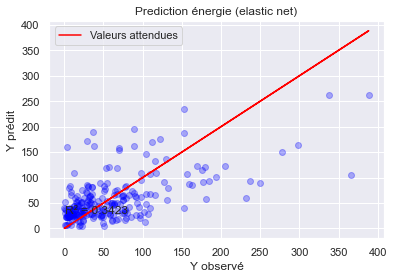

In [129]:
plot_pred_vs_obser(X_test, CO2_test, model_elastic[best], "Prediction énergie (elastic net)", scalerX , scalerY)

### Conclusion regressions linéaires

Le meilleur modèle créé utilise la **régression liniaire Elastic Net** avec un **R² de 0.34** et une erreur moyenne de **36.44**. Le modèle a tendence a sous-estimé l'émission de gaz à effet de serre (au delà de 150 Mt).